In the dynamic tourism industry, the Airbnb platform has transformed both traveler experiences and property owner profits. 

This project aims to build a predictive model for setting nightly prices based on features most strongly connected to price. This framework will help property owners set prices that reflect market dynamics and their property’s unique characteristics.

## Imports

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SequentialFeatureSelector

## Functions

In [5]:
def mvalues(data : pd.DataFrame) -> pd.DataFrame:
    """
    This function takes a DataFrame and returns a new DataFrame with two columns:
    one showing the number of missing values for each column and the other showing the percentage of missing values for each column.
    """
    return ( pd.concat((data.isna().sum(),(data.isna().mean()*100).round(2)),axis=1)
            .rename(columns={0:'missing_values_count',1:'missing_values_percentage'}) )

In [6]:
def split_data(data: pd.DataFrame, target_name: str, frac_test: float,
               seed: int) -> tuple[pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
  X = data.drop(target_name, axis=1)
  y = data[target_name]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=frac_test,
                                                      random_state=seed)
  X_train = X_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_train = y_train.values
  y_test = y_test.values
  return X_train, y_train, X_test, y_test

def add_baseline(y_train, y_test) -> dict:
  return {'model': 'baseline',
          'mse train': np.round(mean_squared_error(y_train, np.full(len(y_train), np.mean(y_train))), 3),
          'mse test': np.round(mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train))), 3),
          'number of features': 0}

def add_model(name: str, model: object, x_train: pd.DataFrame, y_train: np.ndarray,
              x_test: pd.DataFrame, y_test: np.ndarray) -> dict:
  return {'model': name,
          'mse train': np.round(mean_squared_error(y_train, model.predict(x_train)), 3),
          'mse test': np.round(mean_squared_error(y_test, model.predict(x_test)), 3),
          'number of features': x_test.shape[1]}

In [7]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',100)

## Features

In [9]:
pd.read_csv('Listings_data_dictionary.csv',encoding='ISO-8859-1')

,Field,Description
0,listing_id,Listing ID
1,name,Listing Name
2,host_id,Host ID
3,host_since,Date the Host joined Airbnb
4,host_location,Location where the Host is based
5,host_response_time,Estimate of how long the Host takes to respond
6,host_response_rate,Percentage of times the Host responds
7,host_acceptance_rate,Percentage of times the Host accepts a booking request
8,host_is_superhost,Binary field to determine if the Host is a Superhost
9,host_total_listings_count,Total listings the Host has in Airbnb


## Loading

In [11]:
df = pd.read_csv('Listings.csv',encoding='ISO-8859-1')

C:\Users\Koral\AppData\Local\Temp\ipykernel_9400\1110912966.py:1: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Listings.csv',encoding='ISO-8859-1')


## Dataset preparation

Let's start by examining how the data looks like!

In [14]:
df.shape

(279712, 33)

In [15]:
df.tail()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
279707,38338635,Appartement T2 neuf prÃÂ¨s du tram T3a Porte Didot,31161181,2015-04-13,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Observatoire,NaN,Paris,48.82701,2.31419,Entire apartment,Entire place,2,1.0,"[""Iron"", ""Heating"", ""Washer"", ""Dedicated workspace"", ""Elevator"", ""Smoke alarm"", ""Wifi"", ""Kitchen...",120,1,7,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
279708,38538692,Cozy Studio in Montmartre,10294858,2013-11-27,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,NaN,Paris,48.89309,2.33206,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""Iron"", ""Heating"", ""Washer"", ""Hair dryer"", ""Elevator"", ""Wifi"", ""Kitchen"", ""Hot water...",60,7,15,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
279709,38683356,Nice and cosy mini-appartement in Paris,2238502,2012-04-27,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,NaN,Paris,48.88699,2.34920,Entire apartment,Entire place,2,1.0,"[""Paid parking off premises"", ""Shampoo"", ""First aid kit"", ""Heating"", ""Iron"", ""Kitchen"", ""Hair dr...",50,6,30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
279710,39659000,Charming apartment near Rue Saint Maur / Oberkampf,38633695,2015-07-16,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Popincourt,NaN,Paris,48.86687,2.38123,Entire apartment,Entire place,2,1.0,"[""TV"", ""Iron"", ""Kitchen"", ""Hangers"", ""Smoke alarm"", ""Cable TV"", ""Dedicated workspace"", ""Hot wate...",105,3,18,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
279711,40219504,Cosy apartment with view on Canal St Martin,6955618,2013-06-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Enclos-St-Laurent,NaN,Paris,48.87217,2.36320,Entire apartment,Entire place,2,1.0,"[""Shower gel"", ""Shampoo"", ""Iron"", ""Heating"", ""Washer"", ""Dedicated workspace"", ""Extra pillows and...",70,2,4,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f


### Cleansing unused data

In [17]:
df = df.drop(columns=['host_location','latitude','longitude']) # Removing columns that will not be used

In [18]:
df.duplicated().sum()

0

### Missing values

#### Initial exploration

In [21]:
mvalues(df).reset_index()

,index,missing_values_count,missing_values_percentage
0,listing_id,0,0.00
1,name,175,0.06
2,host_id,0,0.00
3,host_since,165,0.06
4,host_response_time,128782,46.04
5,host_response_rate,128782,46.04
6,host_acceptance_rate,113087,40.43
7,host_is_superhost,165,0.06
8,host_total_listings_count,165,0.06
9,host_has_profile_pic,165,0.06


In [22]:
(df.loc[:,'host_total_listings_count']==0).sum() # There are missing values that were "disguised".

33265

In [23]:
df.groupby(['host_id','host_total_listings_count'])['listing_id'].count().reset_index().sort_values('host_id')

,host_id,host_total_listings_count,listing_id
0,1822,5.0,1
1,1944,12.0,11
2,2330,3.0,3
3,2353,1.0,1
4,2438,0.0,1
...,...,...,...
181904,389764135,1.0,1
181905,389953017,2.0,2
181906,390125111,0.0,1
181907,390178153,1.0,1


Hosts may have listings not recorded in this dataset. Therefore it would not be accurate to impute the missing values based on this information.

There are a lot of missing values for the 'district' column. Let's explore why that might be:

In [26]:
df.loc[:,'district'].unique()

array([nan, 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

This feature is specific to New York. Given its limited informative value I'll eliminate it.

In [28]:
df = df.drop(columns='district')

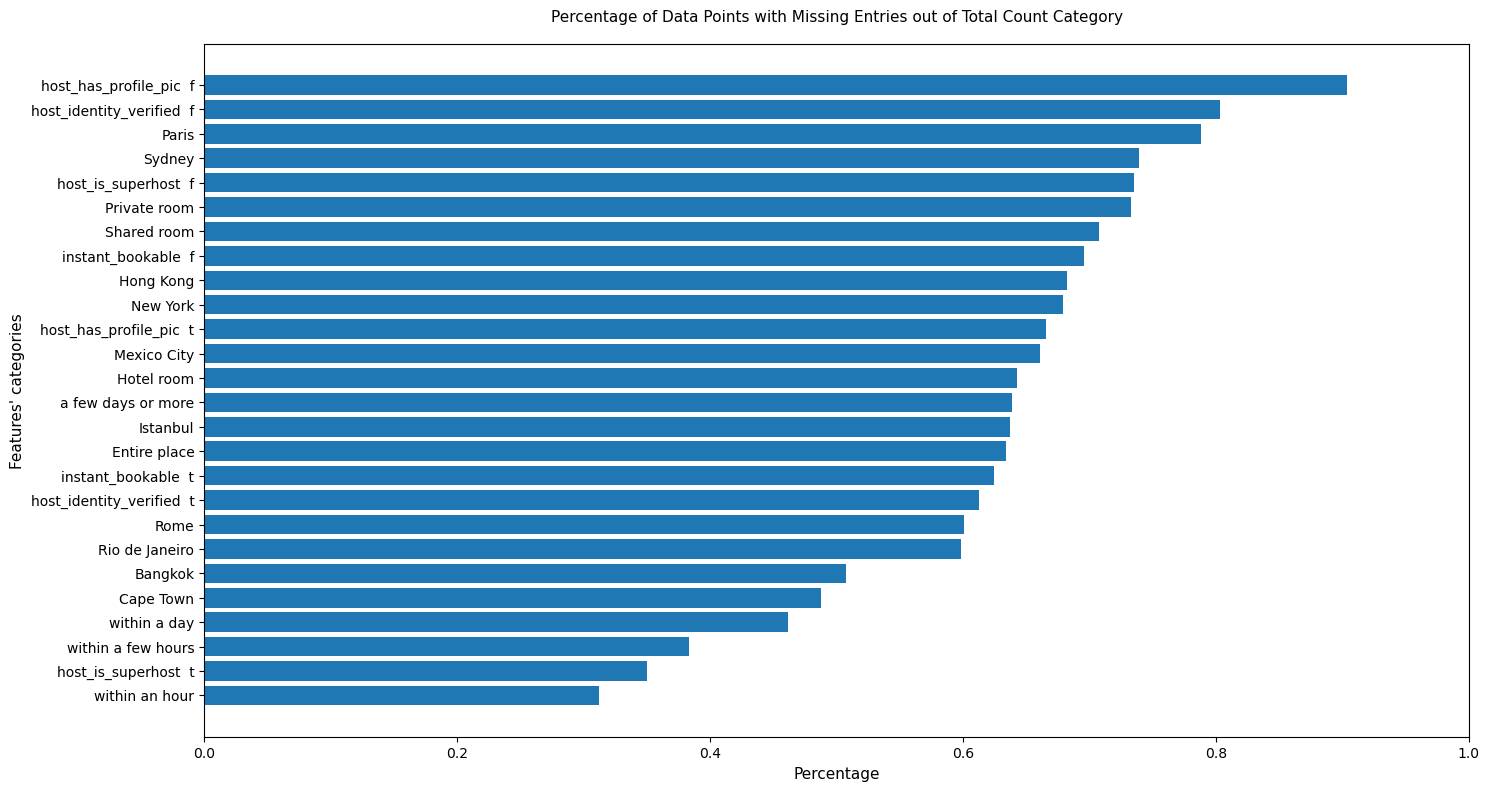

In [52]:
c = ['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified','city','room_type','instant_bookable']

# Creating a table containing the value counts of all the features

value_counts_o = pd.DataFrame(columns=['feature','value','count_original_data'])
for co in c:
    value_counts = df.loc[:,co].value_counts().reset_index().rename(columns={co:'value','count':'count_original_data'})
    value_counts['feature'] = co
    value_counts_o = pd.concat([value_counts_o,value_counts]).reset_index(drop=True)

# The same table only for data containing rows with missing entries

points_with_missing_values = df.loc[df.isna().any(axis=1)]
value_counts_m = pd.DataFrame(columns = ['feature','value','count_missing_data'])
for co in c:
    value_counts = points_with_missing_values.loc[:,co].value_counts().reset_index().rename(columns={co:'value','count':'count_missing_data'})
    value_counts['feature'] = co
    value_counts_m = pd.concat([value_counts_m,value_counts]).reset_index(drop=True)

# Only common categories

value_counts_o = value_counts_o.loc[value_counts_o.loc[:,'value'].isin(set(value_counts_o.loc[:,'value']) & set(value_counts_m.loc[:,'value']))].reset_index(drop = True)

#

value_counts_o['count_missing_data'] = value_counts_m.loc[:,'count_missing_data']

#

value_counts_o['percentage'] = value_counts_o.loc[:,'count_missing_data'] / value_counts_o['count_original_data']

# xticks

def names(point):
    if point.loc['value'] == 't' or point.loc['value'] == 'f':
        return f'{point.loc['feature']}  {point.loc['value']}'
    return point.loc['value']

value_counts_o['value'] = value_counts_o.apply(names,axis = 1)

#

value_counts_o=value_counts_o.sort_values('percentage',ascending=False)

# chart

plt.figure(figsize=(15,8))

plt.barh(value_counts_o.loc[:,'value'],value_counts_o.loc[:,'percentage'])

plt.title('Percentage of Data Points with Missing Entries out of Total Count Category',fontsize=11,y=1.02)
plt.xlabel('Percentage',fontsize=11)
plt.ylabel("Features' categories",fontsize=11)
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.tight_layout()
plt.show()

A substantial percentage of values in several categories would be removed. However the missing values are not concentrated within specific categories but are distributed throughout the dataset. Considering that imputation could introduce inaccuracy and uncertainty by generating speculative values I chose to remove the points containing missing values.

In [262]:
df = df.dropna()

### Transformation of prices

Let's transform the prices which are expressed in different units into US dollars.

In [265]:
print(df.loc[:,'city'].unique())

['Paris' 'New York' 'Bangkok' 'Mexico City' 'Cape Town' 'Istanbul' 'Rome'
 'Hong Kong' 'Rio de Janeiro' 'Sydney']


In [266]:
prices = {
    'Paris': 0.85,
    'New York': 1.0,
    'Bangkok': 0.030,
    'Rio de Janeiro': 0.18,
    'Sydney': 0.75,
    'Istanbul': 0.12,
    'Rome': 1.20,
    'Hong Kong': 0.13,
    'Mexico City': 0.050,
    'Cape Town': 0.066
}

df['price'] = df.apply(lambda point : prices[point.loc['city']] * point.loc['price'], axis=1)

### Representation of variables

#### Booleans

In [269]:
booleans = ('host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable')

for f in booleans:
        df[f] = df.loc[:,f].map({'t':True,'f':False})

#### Amenities

In [271]:
df.loc[:,'amenities'].iloc[20] # Amenities feature needs to be represented in another manner.

'["Heating", "TV", "Iron", "Kitchen", "Essentials", "Hair dryer", "Washer", "Dryer", "Stove", "Refrigerator", "Dishwasher", "Coffee maker", "Wifi", "Dishes and silverware", "Long term stays allowed", "Host greets you"]'

In [272]:
amenities = ['TV','FREEZER','WIFI','KITCHEN','WASHER','DRYER','AIR CONDITIONING','HEATING','WORKSPACE','IRON','POOL','FREE PARKING','CRIB',
             'BBQ GRILL','INDOOR FIREPLACE','HOT TUB','EV CHARGER','GYM','BREAKFAST','SMOKING ALLOWED','BEACHFRONT','WATERFRONT','SMOKE ALARM','CARBON MONOXIDE ALARM']

# amenities listed on the AIRBNB website

for i in amenities:
  df[i] = None
  df[i] = df.loc[:,'amenities'].apply(lambda x : i in x.upper()) # Binary columns indicate whether the listing has a specific amenity

df = df.drop(columns=['amenities'])

#### Minimum nights & Maximum nights

In [274]:
df.loc[:,['minimum_nights','maximum_nights']].describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                     0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).drop(index=['count','mean','std']).transpose()

,min,1%,5%,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,95%,99%,99.9%,max
minimum_nights,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,10.0,30.0,30.0,181.358,1000.0
maximum_nights,1.0,6.0,15.0,29.0,40.0,90.0,120.0,365.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.0,1125.000,999999999.0


In 'maximum_nights' there is a very large gap between the 99.9th percentile and the maximum value which presente "strange" number. Let's explore this a little deeper.

In [276]:
df.loc[df.loc[:,'maximum_nights'].nlargest(50).index,['minimum_nights','maximum_nights']].transpose()

,268454,159137,205366,202804,157834,186141,186333,222113,159828,186768,186769,166172,222985,224736,245587,245589,245874,246082,247182,224635,186254,219357,225709,247986,245959,243442,241377,185328,205363,205364,205365,205367,205471,234827,172749,182297,182377,241122,247725,266336,211104,189648,235675,250172,264629,267493,26273,26274,26275,26276
minimum_nights,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,3,1,90,1,2,3,2,2,30,1,1,1,1,1,2,10,5,5,3,1,2,1,30,1,2,15,3,1,1,1,30
maximum_nights,999999999,999999,200000,99999,50000,50000,50000,47036,30000,30000,30000,10000,10000,10000,9999,9999,9999,9999,9999,7000,5000,5000,3659,3500,3333,3000,2500,2100,2000,2000,2000,2000,2000,2000,1918,1825,1825,1825,1200,1200,1162,1126,1126,1126,1126,1126,1125,1125,1125,1125


Hosts with very large and "strange" maximum nights have a minimal night requirement indicating they are likely flexible and do not have a strict time limit. However some listings are aimed at longer stays such as the one requiring a minimum of 90 nights.

I'll create a new attribute to better capture the underlying information these features hold.

We can get a sense from the AIRBNB website at [this link](https://he.airbnb.com/resources/hosting-homes/a/understanding-your-calendar-and-booking-settings-16) regarding what is considered a long length of stay (28).

In [280]:
def new(point):

    if point.loc['minimum_nights'] >= 28:
        return 'Long'
    if point.loc['maximum_nights'] <= 14:
        return 'Short'
    else:
        return 'Flexible'

df['stay_duration'] = df.apply(new,axis=1)

In [281]:
df = df.drop(columns=['maximum_nights','minimum_nights'])

### Errors

#### Initial exploration

In [284]:
df.drop(columns=['listing_id','host_id']).describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                  0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).drop(index=['count','mean','std']).transpose().reset_index().rename(columns={'index':'feature'})

,feature,min,1%,5%,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,95%,99%,99.9%,max
0,host_response_rate,0.00,0.0,0.33,0.7,0.90,0.96,1.00,1.000,1.00,1.000,1.0,1.0,1.0,1.0,1.0000,1.0000,1.00000,1.0
1,host_acceptance_rate,0.00,0.0,0.22,0.5,0.76,0.83,0.89,0.950,0.98,1.000,1.0,1.0,1.0,1.0,1.0000,1.0000,1.00000,1.0
2,host_total_listings_count,0.00,0.0,0.00,1.0,1.00,1.00,1.00,2.000,3.00,4.000,6.0,8.0,11.0,28.0,59.0000,199.0000,1105.00000,7235.0
3,accommodates,1.00,1.0,1.00,2.0,2.00,2.00,2.00,2.000,3.00,4.000,4.0,5.0,5.0,6.0,8.0000,12.0000,16.00000,16.0
4,bedrooms,1.00,1.0,1.00,1.0,1.00,1.00,1.00,1.000,1.00,1.000,2.0,2.0,2.0,3.0,3.0000,5.0000,10.00000,50.0
5,price,5.52,10.2,15.00,20.4,30.00,34.95,39.60,49.566,61.05,76.032,96.0,109.2,127.5,195.5,295.7304,694.1529,1969.88478,23234.4
6,review_scores_rating,20.00,60.0,80.00,85.0,90.00,92.00,93.00,95.000,96.00,98.000,99.0,100.0,100.0,100.0,100.0000,100.0000,100.00000,100.0
7,review_scores_accuracy,2.00,6.0,8.00,9.0,9.00,9.00,10.00,10.000,10.00,10.000,10.0,10.0,10.0,10.0,10.0000,10.0000,10.00000,10.0
8,review_scores_cleanliness,2.00,5.0,8.00,8.0,9.00,9.00,9.00,9.000,10.00,10.000,10.0,10.0,10.0,10.0,10.0000,10.0000,10.00000,10.0
9,review_scores_checkin,2.00,6.0,9.00,9.0,10.00,10.00,10.00,10.000,10.00,10.000,10.0,10.0,10.0,10.0,10.0000,10.0000,10.00000,10.0


In [285]:
df.sample(10)

,listing_id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,city,property_type,room_type,accommodates,bedrooms,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,TV,FREEZER,WIFI,KITCHEN,WASHER,DRYER,AIR CONDITIONING,HEATING,WORKSPACE,IRON,POOL,FREE PARKING,CRIB,BBQ GRILL,INDOOR FIREPLACE,HOT TUB,EV CHARGER,GYM,BREAKFAST,SMOKING ALLOWED,BEACHFRONT,WATERFRONT,SMOKE ALARM,CARBON MONOXIDE ALARM,stay_duration
92655,38931029,Lindo apartamento na Barra da Tijuca,125450353,2017-04-11,within a day,0.57,0.50,False,1.0,True,False,Barra da Tijuca,Rio de Janeiro,Entire condominium,Entire place,4,2.0,63.000,100.0,10.0,10.0,10.0,10.0,10.0,9.0,False,True,False,True,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,Flexible
225415,40240103,Amazing location apartment! Comfortable and clean.,150848657,2017-09-16,within a day,0.90,0.91,True,3.0,True,True,Cuauhtemoc,Mexico City,Entire apartment,Entire place,3,1.0,30.000,100.0,10.0,10.0,9.0,10.0,10.0,10.0,True,True,False,True,True,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Flexible
47182,38817828,Quartos em Copacabana proximo ÃÂ praia e metro.,66557090,2016-04-10,within a day,0.50,0.67,False,2.0,True,True,Copacabana,Rio de Janeiro,Entire apartment,Entire place,5,1.0,21.600,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Flexible
63196,5572031,Top Modern 2brm 2bath Bondi Pad,6846033,2013-06-10,within an hour,1.00,0.14,False,3.0,True,True,Waverley,Sydney,Entire apartment,Entire place,4,2.0,129.000,91.0,10.0,9.0,9.0,9.0,10.0,9.0,False,True,False,True,True,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,Flexible
159292,30590252,Gem in Tokai,211459149,2018-08-24,within a few hours,1.00,0.80,True,1.0,True,False,Ward 71,Cape Town,Entire guest suite,Entire place,4,1.0,69.300,100.0,10.0,10.0,10.0,10.0,10.0,10.0,True,True,False,True,True,False,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,Flexible
80566,8790559,"Walk to the beach - Pool, Seaviews, Style, Comfort",25122328,2014-12-23,within an hour,1.00,0.45,True,27.0,True,True,Ward 54,Cape Town,Entire villa,Entire place,10,5.0,599.082,95.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,True,True,Flexible
239364,40905569,Near The Grand Palace/ASOK Station/Sukhumvit,201677068,2018-07-11,within an hour,1.00,0.99,False,162.0,True,True,Khlong Toei,Bangkok,Entire apartment,Entire place,4,2.0,130.290,100.0,10.0,10.0,10.0,10.0,10.0,10.0,True,True,False,True,True,True,True,True,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,True,True,Flexible
175143,632286,95spezie Your Home in Rome 2,3140237,2012-08-02,within an hour,1.00,1.00,True,3.0,True,True,VII San Giovanni/Cinecitta,Rome,Private room in bed and breakfast,Private room,2,1.0,42.000,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,False,True,False,False,True,True,True,True,True,False,False,True,False,False,False,False,False,True,False,False,False,True,True,Flexible
35064,9057495,2-Bed BEACHFRONT apartment with SEA&MOUNTAIN VIEWS,33564650,2015-05-17,within a few hours,0.92,0.92,False,1.0,True,True,Ward 54,Cape Town,Entire apartment,Entire place,4,2.0,64.878,93.0,9.0,9.0,9.0,10.0,10.0,9.0,False,True,True,True,True,True,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,Tru

Based on the maximum values for bedrooms and accommodates it seems that a listing can have more bedrooms than accommodates. This doesn’t make much sense as a host wouldn't assign a larger space to a smaller number of accommodates. Let's explore some specific cases:

In [287]:
df.loc[[202797,81427]]

,listing_id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,city,property_type,room_type,accommodates,bedrooms,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,TV,FREEZER,WIFI,KITCHEN,WASHER,DRYER,AIR CONDITIONING,HEATING,WORKSPACE,IRON,POOL,FREE PARKING,CRIB,BBQ GRILL,INDOOR FIREPLACE,HOT TUB,EV CHARGER,GYM,BREAKFAST,SMOKING ALLOWED,BEACHFRONT,WATERFRONT,SMOKE ALARM,CARBON MONOXIDE ALARM,stay_duration
202797,20768013,La Louisiane the heart of Saint-Germain des Pres,46443228,2015-10-13,within an hour,1.0,1.00,False,43.0,True,True,Luxembourg,Paris,Room in boutique hotel,Private room,16,50.0,39.1,92.0,10.0,9.0,10.0,10.0,10.0,10.0,False,True,False,True,True,True,True,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,True,True,True,Flexible
81427,39564283,Sanctuary Home with Pool & Gym - 5 mins to Beach,167072223,2018-01-10,within an hour,1.0,0.94,False,8.0,True,True,Randwick,Sydney,Entire house,Entire place,1,5.0,900.0,100.0,10.0,10.0,10.0,10.0,10.0,9.0,False,True,False,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,True,False,False,False,False,True,True,Flexible


The analysis reveals inconsistencies within the dataset.

We can understand that this incongruence could be attributed to a misunderstanding when entering data. The total number of rooms in the property might have been recorded instead of just those relevant to the listing. ( Thus for example while a property may have 50 rooms the listing may only accommodate 16 guests with private rooms ). According to the variable descriptions 'bedrooms' and 'accommodates' should refer to the listing.

There are also issues with room type classification. 'Room in boutique hotel' is categorized as a 'Private Room' instead of 'Hotel Room'. While the second listing may be a shared space for five people who each have a room ( and the listing is for just one person ) the room type is 'Entire place'. These incongruences could be due to arbitrary data entry practices or the host’s misunderstanding of the category definitions..

In [289]:
df.loc[[78352,92785]] # similar cases

,listing_id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,city,property_type,room_type,accommodates,bedrooms,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,TV,FREEZER,WIFI,KITCHEN,WASHER,DRYER,AIR CONDITIONING,HEATING,WORKSPACE,IRON,POOL,FREE PARKING,CRIB,BBQ GRILL,INDOOR FIREPLACE,HOT TUB,EV CHARGER,GYM,BREAKFAST,SMOKING ALLOWED,BEACHFRONT,WATERFRONT,SMOKE ALARM,CARBON MONOXIDE ALARM,stay_duration
78352,31653072,"Luxury Style,Walking to Darling Harbour,QVB,ICC.",189112177,2018-05-11,within an hour,1.00,0.89,False,28.0,True,True,Sydney,Sydney,Room in apartment,Hotel room,4,2.0,94.500,90.0,8.0,9.0,9.0,9.0,10.0,9.0,False,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Flexible
92785,32058438,Kylemore 407 - Two Bedroom Apartment,130248430,2017-05-14,within an hour,0.95,0.94,False,323.0,True,True,Ward 115,Cape Town,Room in apartment,Hotel room,4,2.0,337.458,100.0,10.0,10.0,10.0,10.0,10.0,10.0,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,Flexible


In [290]:
df.loc[df.loc[:,'property_type'] == 'Room in aparthotel','room_type'].value_counts() # an apartment hotel can be interpreted as a room or entire place

room_type
Entire place    309
Private room    153
Hotel room      117
Name: count, dtype: int64

In [291]:
df = df.loc[df.loc[:,'bedrooms'] <= df.loc[:,'accommodates']]
df.loc[df.loc[:,'property_type'].isin(('Room in boutique hotel','Room in hotel')),'room_type'] = 'Hotel room'
df.loc[df.loc[:,'listing_id'] == 39564283,'room_type'] = 'Private room'
df.loc[df.loc[:,'property_type'] == 'Room in apartment','room_type'] = 'Private room'
df.loc[df.loc[:,'property_type'] == 'Room in aparthotel','room_type'] = 'Entire place' # most common

###  Cleaning unused data

In [293]:
{'nuniques' : df.loc[:,'neighbourhood'].nunique(), 'nuniques with 10 listings or fewer' : df.loc[:,'neighbourhood'].value_counts()[df.loc[:,'neighbourhood'].value_counts() < 10].shape[0]}

{'nuniques': 595, 'nuniques with 10 listings or fewer': 214}

In [294]:
{'nuniques' : df.loc[:,'property_type'].nunique(), 'nuniques with 10 listings or fewer' : df.loc[:,'property_type'].value_counts()[df.loc[:,'property_type'].value_counts() < 10].shape[0]}

{'nuniques': 105, 'nuniques with 10 listings or fewer': 48}

There are a lot of categories with low counts. These variables pose a challenge in dividing the data into training and test sets as effective model learning requires representation of categories in both sets.

The features 'city' and 'room type' have already merged similar categories which increases the risk of multicollinearity.

In [296]:
df = df.drop(columns=['neighbourhood','property_type'])

### Log

In [298]:
print('mean {} median {}'.format(df.loc[:,'price'].mean(),df.loc[:,'price'].median()))

mean 101.62826732620036 median 61.199999999999996


As evident from the provided statistics the price distribution displays a right-skewed pattern (median falling below the mean). Let's use a logarithmic function to target variable to better fit a linear model.

In [300]:
df['price'] = np.log(df.loc[:,'price'])

### Feature engineering

Let's generate novel features by leveraging the existing data attributes!

In [303]:
df['num_amenities'] = df.loc[:,amenities].sum(axis=1) # A variable that describes the number of amenities in the property

I'll create a feature representing the host's duration of membership with Airbnb. This metric could indicate the host's level of experience and tenure on the platform. (2021 is the most recent update date of the data).

In [305]:
df['host_since_years'] = df.loc[:,'host_since'].apply(lambda x : 2021 - int(x.split('-')[0]))

### Data Type issues

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92995 entries, 26273 to 271185
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   92995 non-null  int64  
 1   name                         92995 non-null  object 
 2   host_id                      92995 non-null  int64  
 3   host_since                   92995 non-null  object 
 4   host_response_time           92995 non-null  object 
 5   host_response_rate           92995 non-null  float64
 6   host_acceptance_rate         92995 non-null  float64
 7   host_is_superhost            92995 non-null  bool   
 8   host_total_listings_count    92995 non-null  float64
 9   host_has_profile_pic         92995 non-null  bool   
 10  host_identity_verified       92995 non-null  bool   
 11  city                         92995 non-null  object 
 12  room_type                    92995 non-null  object 
 13  accommodates    

Let's perform type casting to set the appropriate types for each feature.

In [309]:
casting = { 'name' : 'string', 'host_response_time' : 'string', 'city' : 'string', 'room_type' : 'string','stay_duration' : 'string',
            'host_total_listings_count' : 'int','bedrooms' : 'int','review_scores_rating' : 'int', 'review_scores_accuracy' : 'int', 'review_scores_cleanliness' : 'int', 'review_scores_checkin' : 'int', 'review_scores_communication' : 'int', 'review_scores_location' : 'int', 'review_scores_value' : 'int',
            'host_since' : 'datetime64[ns]'
}

df = df.astype(casting)

Let's perform type casting to optimize memory usage.

In [311]:
for c in df.tail().select_dtypes(include='number'):
    if c in df.tail().select_dtypes(include='float'):
       df[c] = pd.to_numeric(df.loc[:,c],downcast='float')
    else:
       df[c] = pd.to_numeric(df.loc[:,c],downcast='integer')

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92995 entries, 26273 to 271185
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   listing_id                   92995 non-null  int32         
 1   name                         92995 non-null  string        
 2   host_id                      92995 non-null  int32         
 3   host_since                   92995 non-null  datetime64[ns]
 4   host_response_time           92995 non-null  string        
 5   host_response_rate           92995 non-null  float32       
 6   host_acceptance_rate         92995 non-null  float32       
 7   host_is_superhost            92995 non-null  bool          
 8   host_total_listings_count    92995 non-null  int16         
 9   host_has_profile_pic         92995 non-null  bool          
 10  host_identity_verified       92995 non-null  bool          
 11  city                         92995 non-nu

### Outliers

In [314]:
features = ['host_response_rate','host_acceptance_rate','host_total_listings_count','price']

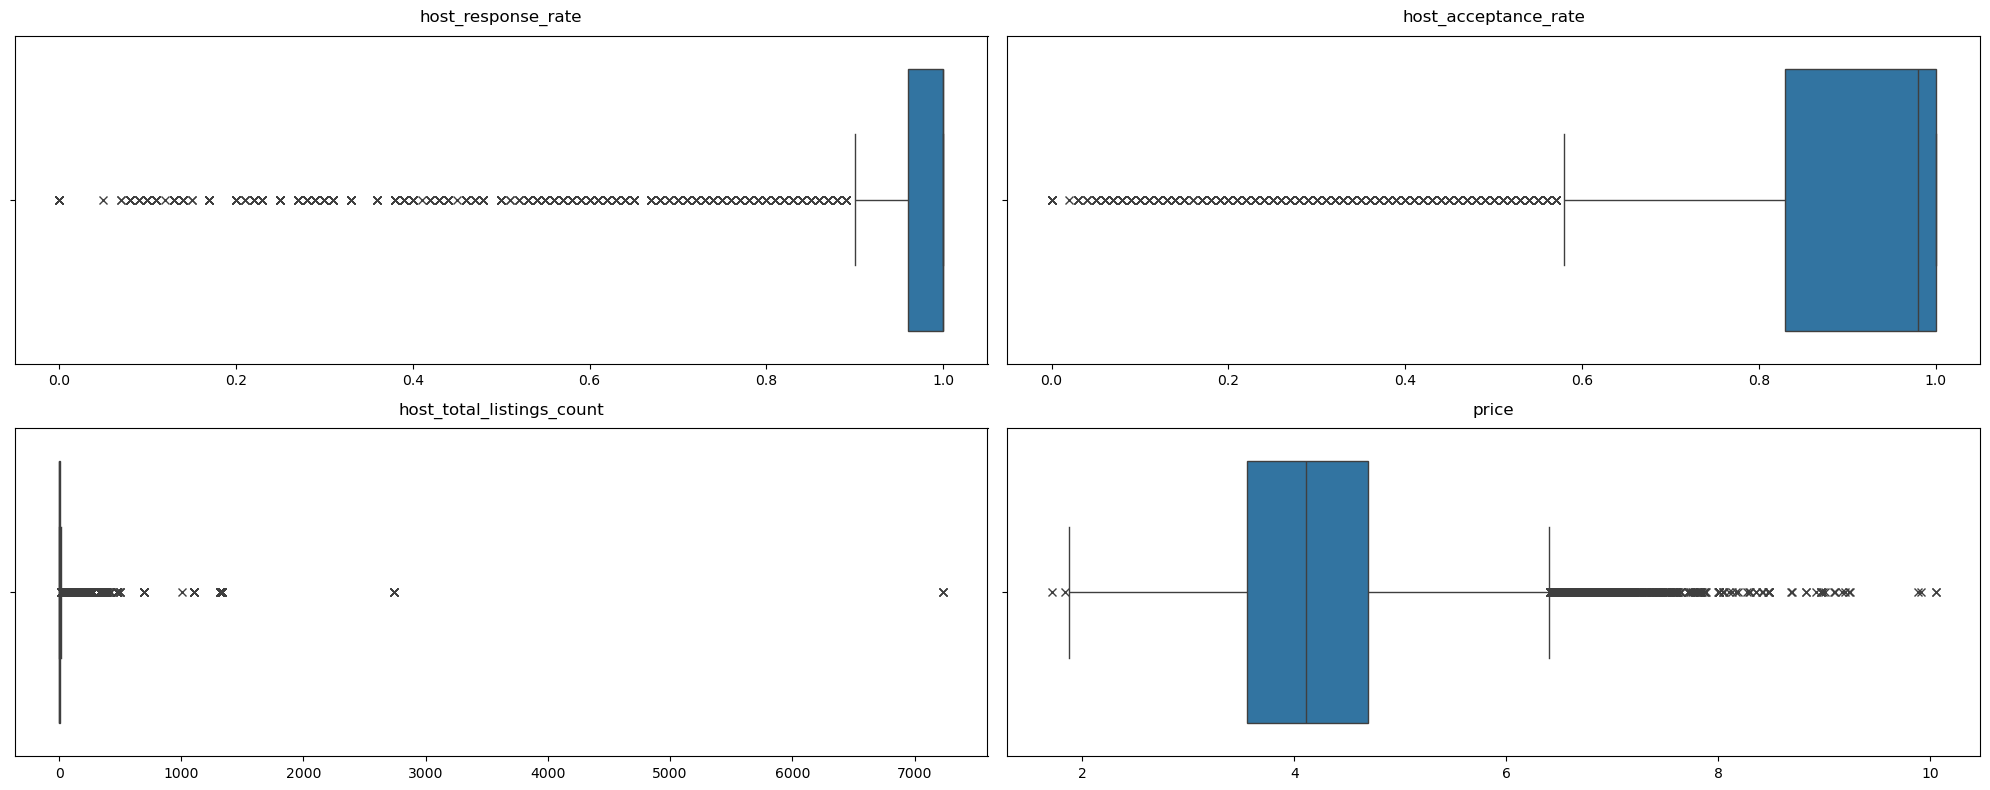

In [315]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    ax = axs[row,col]
    sns.boxplot(x=feature, flierprops={'marker':'x'}, data=df, ax=ax)
    ax.set_title(feature, y=1.02)
    ax.set_xlabel('')

plt.tight_layout()

In [316]:
df = ( df.loc[( (df.loc[:,'host_response_rate'] > 0.9) & 
              (df.loc[:,'host_acceptance_rate'] > 0.6) 
              & (df.loc[:,'host_total_listings_count'] < 20)  & (df.loc[:,'price'] < 7.5) ),:]
              .reset_index(drop=True) )

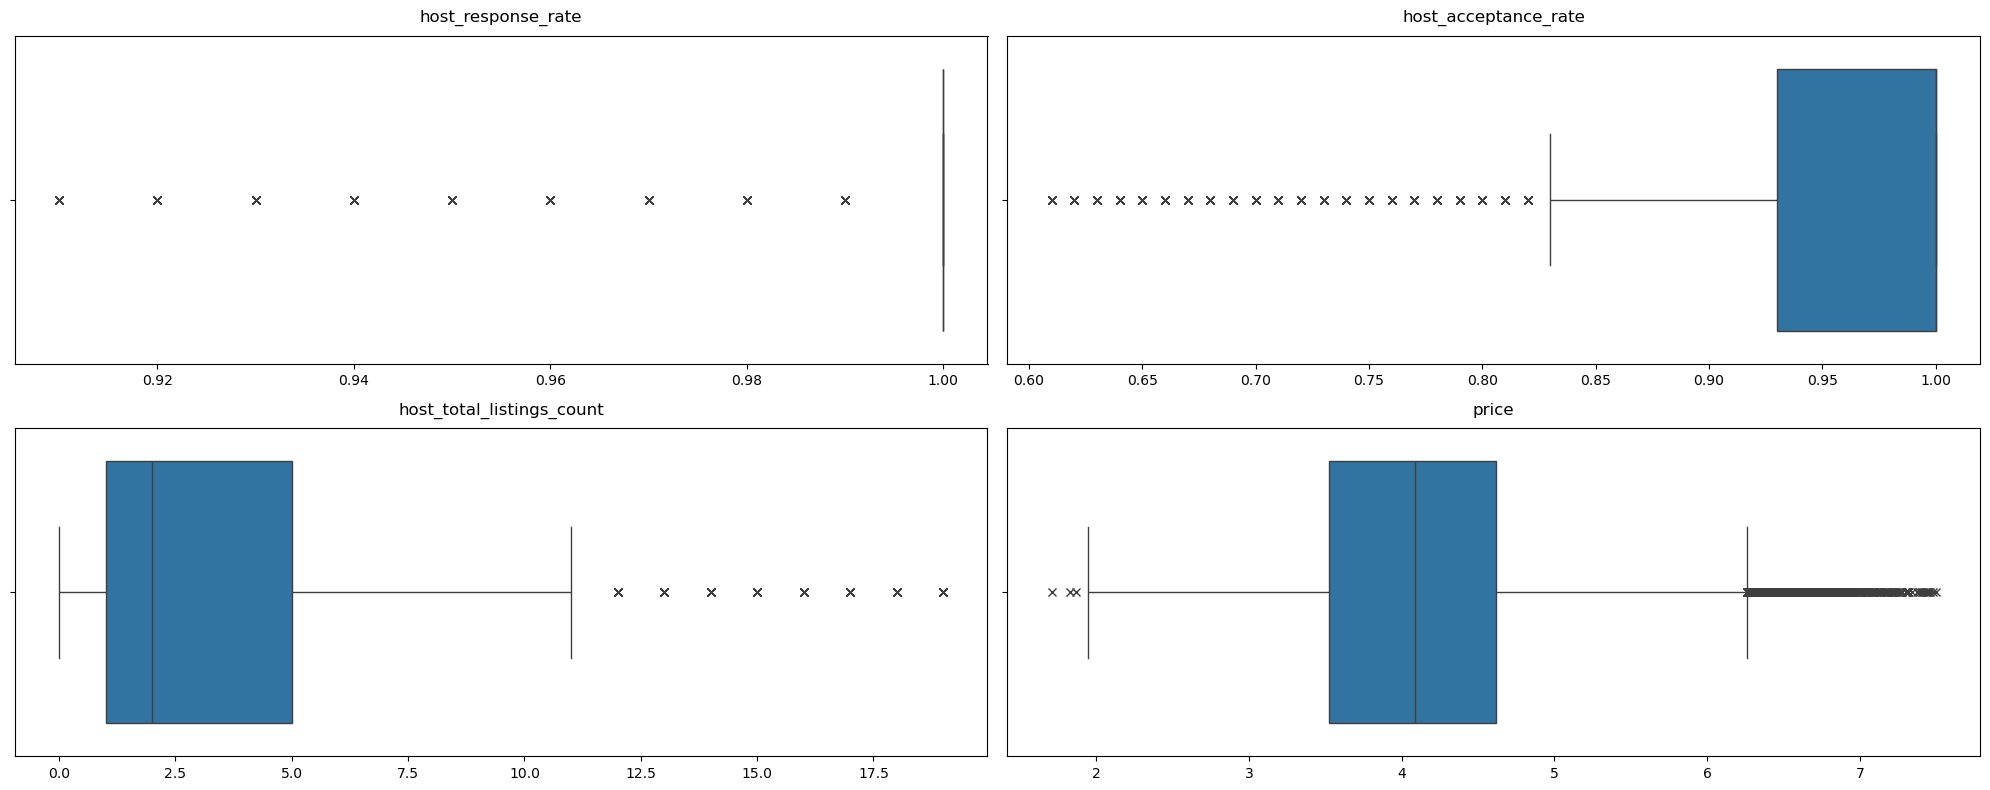

In [317]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    ax = axs[row,col]
    sns.boxplot(x=feature, flierprops={'marker':'x'}, data=df, ax=ax)
    ax.set_title(feature, y=1.02)
    ax.set_xlabel('')

plt.tight_layout()

One technique in managing outliers within multidimensional data is examining the distribution of distances between each data point and its closest neighbor. Let's use it to examine further the dataset's structure after removing outliers.

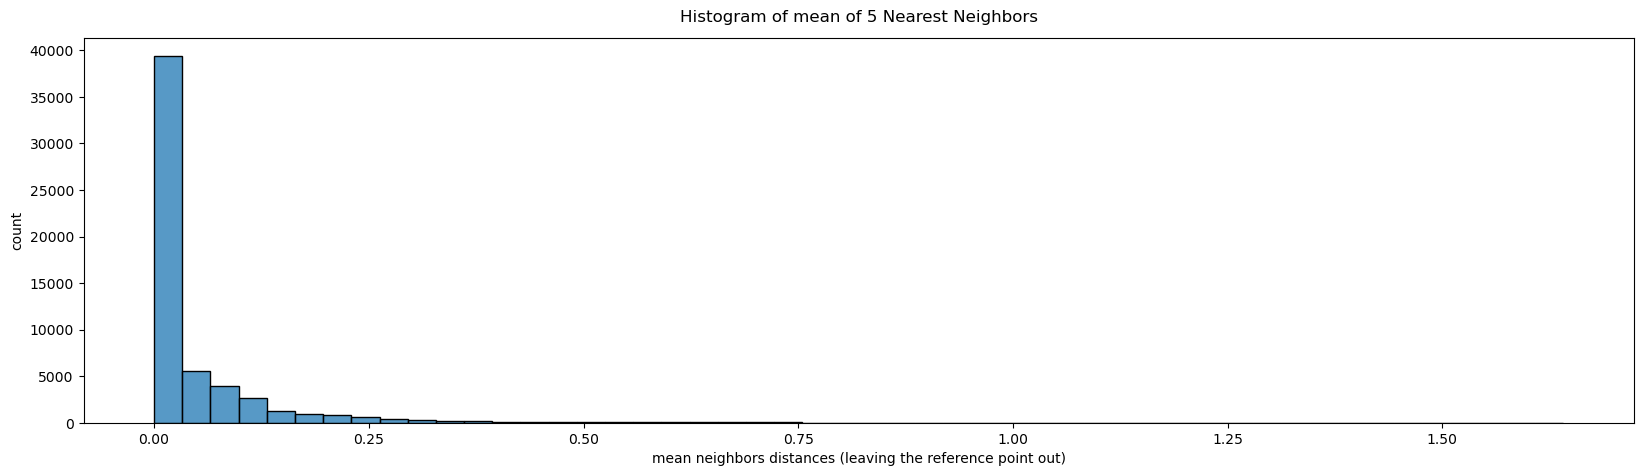

In [319]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[features])
normalized_df = pd.DataFrame(normalized_data, columns = df[features].columns)

n = NearestNeighbors(metric='euclidean')
n.fit(normalized_df)

distances, _ = n.kneighbors(normalized_df, 6)
mean_distances = distances[:,1:].mean(axis=1)
plt.figure(figsize=(20,5))
sns.histplot(mean_distances, bins=50)
plt.xlabel('mean neighbors distances (leaving the reference point out)')
plt.title('Histogram of mean of 5 Nearest Neighbors', fontsize=12, y=1.02)
plt.ylabel('count');

This histogram illustrates the mean Euclidean distances for each data point computed from its five nearest neighbors. Before applying the algorithm normalization was performed due to the varying units of our features. IT'S LOOK GOOD!

## EDA

The initial EDA supported the preprocessing by building familiarity with the raw data and identifying data quality issues - guiding adjustments. With this basic step complete the data is now clean and the focus shifts to a more comprehensive EDA to explore basic patterns in the data.

### Initial exploration

In [324]:
df.shape

(56945, 51)

In [325]:
df.tail()

,listing_id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,city,room_type,accommodates,bedrooms,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,TV,FREEZER,WIFI,KITCHEN,WASHER,DRYER,AIR CONDITIONING,HEATING,WORKSPACE,IRON,POOL,FREE PARKING,CRIB,BBQ GRILL,INDOOR FIREPLACE,HOT TUB,EV CHARGER,GYM,BREAKFAST,SMOKING ALLOWED,BEACHFRONT,WATERFRONT,SMOKE ALARM,CARBON MONOXIDE ALARM,stay_duration,num_amenities,host_since_years
56940,44273734,Charming duplex near JARDIN DU LUXEMBOURG,356893366,2020-07-17,within an hour,1.0,1.0,False,1,True,False,Paris,Entire place,5,1,4.906385,100,10,10,10,10,10,10,False,True,False,True,True,True,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,Flexible,9,1
56941,44339814,Appartement piscine place d'Italie,3909173,2012-10-18,within a few hours,1.0,1.0,False,1,True,True,Paris,Entire place,3,1,4.432601,100,10,10,10,10,10,10,True,True,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,False,True,False,False,False,True,False,Flexible,12,9
56942,45200617,Cozy Montmartre flat near Le Moulin Rouge,73974623,2016-05-25,within a day,1.0,1.0,False,1,True,True,Paris,Entire place,3,1,4.219508,100,10,10,10,10,10,10,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Flexible,10,5
56943,46673032,Moderne-ancien- jungle urbaine - proche Montmartre,2470431,2012-05-26,within an hour,1.0,1.0,False,1,True,True,Paris,Entire place,3,1,3.964615,100,10,10,10,10,10,10,False,True,False,True,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Short,8,9
56944,46768757,Appartement tranquille au cÃ âur du 5ÃÂ¨me arr. (35mÃÂ²),32365856,2015-05-01,within an hour,1.0,1.0,False,1,True,True,Paris,Entire place,3,1,3.931826,100,10,8,10,10,10,10,True,False,True,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Short,6,6


C:\Users\Koral\AppData\Local\Temp\ipykernel_23732\837262755.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:,'price']);


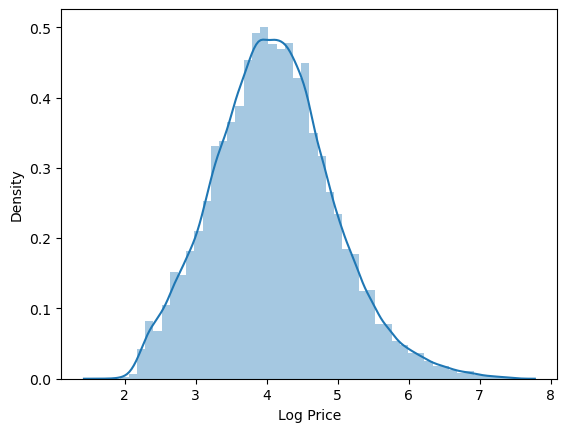

In [326]:
sns.distplot(df.loc[:,'price']);
plt.xlabel('Log Price');

Through implementing logarithmic scale for the price I have managed to visualize its distribution resembling a Gaussian curve.

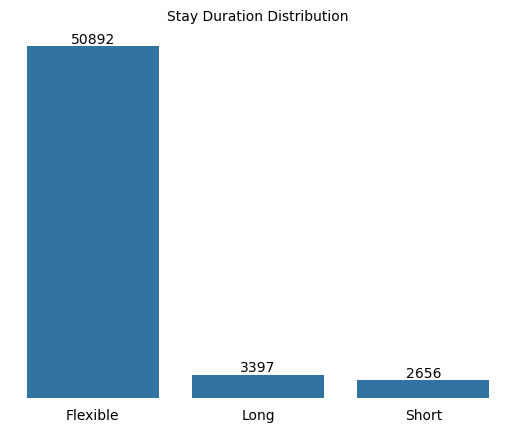

In [328]:
ax = sns.countplot(x=df.loc[:,'stay_duration']);
plt.title('Stay Duration Distribution',fontsize=10);
plt.xlabel('');
plt.ylabel('');
sns.despine(bottom=True,left=True);
ax.xaxis.set_ticks_position('none');
plt.yticks(ticks=[]);
ax.bar_label(ax.containers[0]);

Most hosts are flexible in terms of the length of stay.

C:\Users\Koral\AppData\Local\Temp\ipykernel_23732\1530749254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df[amenities].sum().sort_values(ascending=False).index,


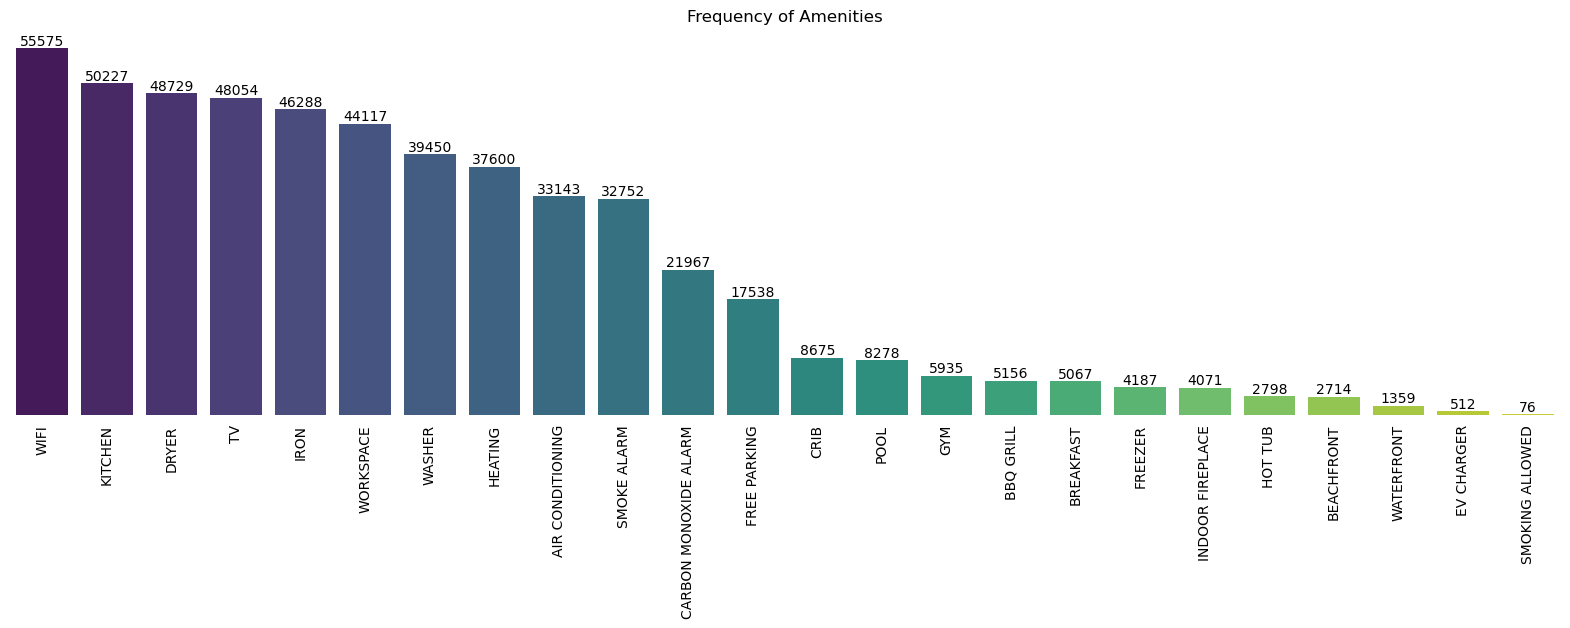

In [330]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x=df[amenities].sum().sort_values(ascending=False).index, 
                 y=df[amenities].sum().sort_values(ascending=False).values,
                 palette='viridis');

plt.title('Frequency of Amenities', fontsize=12)
plt.xlabel('')
plt.ylabel('')

sns.despine(bottom=True, left=True)
ax.xaxis.set_ticks_position('none')
plt.yticks(ticks=[])

for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=90)
plt.show()

Common amenities include Wi-Fi, a kitchen, a dryer, and a TV, while the rarest are access to the sea, a fireplace, and a jacuzzi (amenities considered to be luxurious).

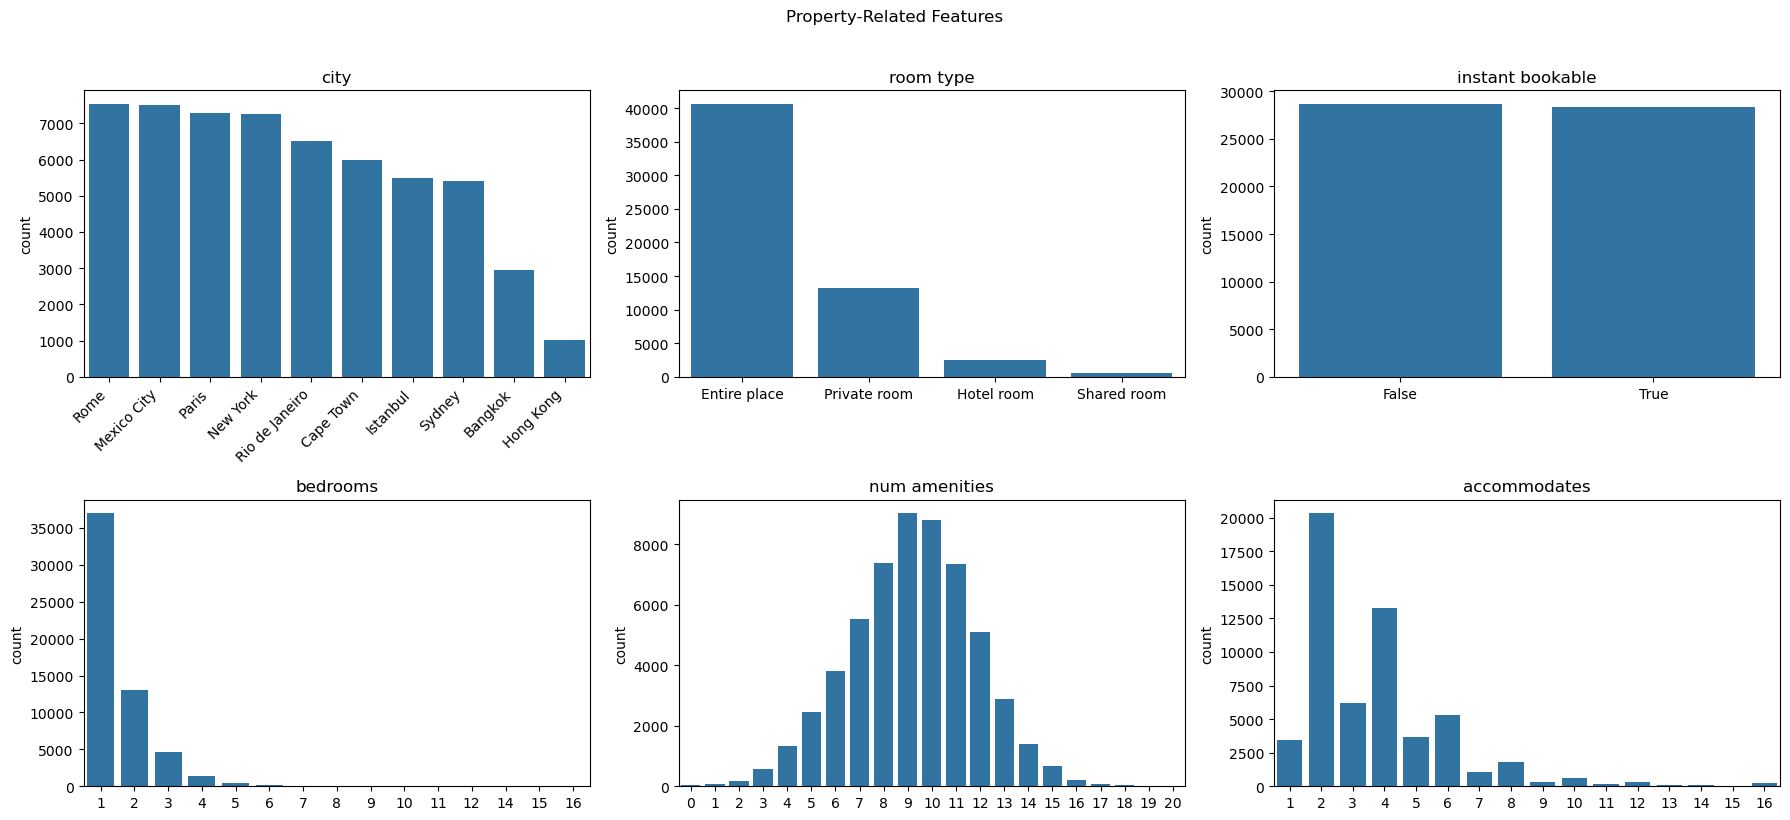

In [332]:
my_x_labels=['City','Room Type','Instant Bookable','Number of Bedrooms','Number of Amenities','Acommodates']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
ordered_features = ['city','room_type','instant_bookable']
for idx, feature in enumerate(['city','room_type','instant_bookable','bedrooms','num_amenities','accommodates']):
    feature_value_counts = df[feature].value_counts().sort_index().reset_index()
    feature_value_counts.columns = [feature, 'count']
    row_idx = idx // 3
    col_idx = idx % 3
    plt.sca(axs[row_idx, col_idx])
    if feature in ordered_features:
        order = df[feature].value_counts().index
        sns.barplot(x=feature, y='count', data=feature_value_counts, order=order)
    else:
        sns.barplot(x=feature, y='count', data=feature_value_counts)
    if feature == "city":
        plt.xticks(rotation=45, ha="right")
    plt.xlabel('')
    plt.ylabel('count')
    plt.title(feature.replace('_', ' '))
    if feature == 'instant_bookable':
        xtick_labels = [0, 1]  # Use numerical values
        plt.xticks(xtick_labels, ['False', 'True'])  # Set custom tick labels

fig.suptitle('Property-Related Features', fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)  # Adjust the values as needed
plt.tight_layout()
plt.show()

In the room type feature, most properties are entire places, with fewer examples of private, hotel, and especially shared rooms. As expected,  bedrooms and accommodates are right-skewed.

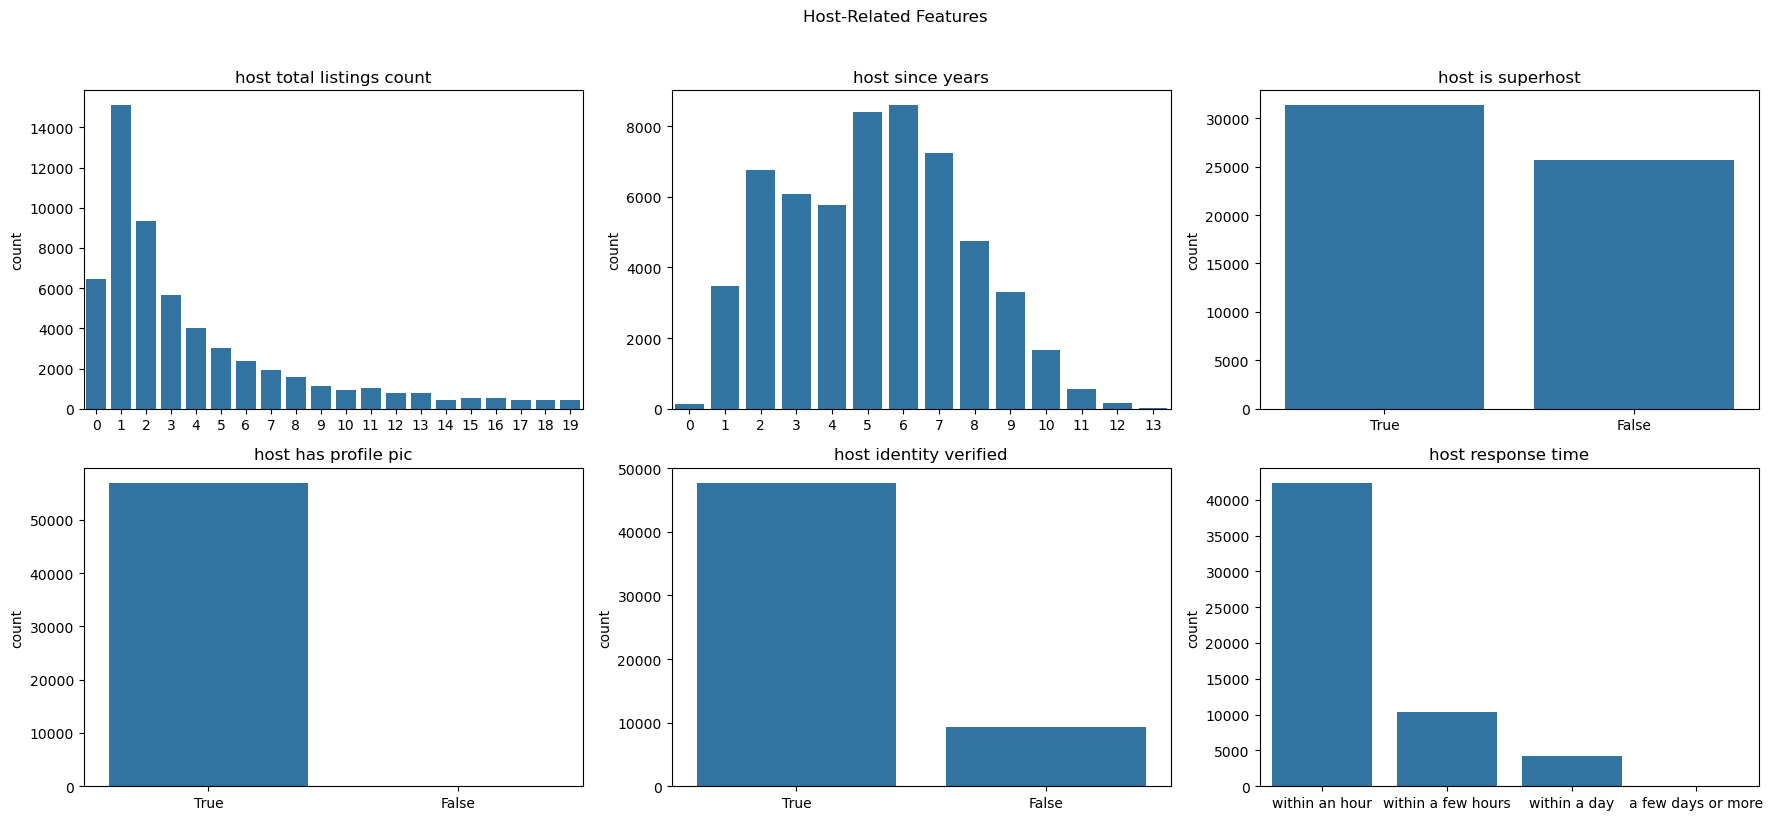

In [334]:
vars = ['host_total_listings_count','host_since_years','host_is_superhost','host_has_profile_pic','host_identity_verified','host_response_time']
ordered_features = ['host_has_profile_pic', 'host_identity_verified', 'host_response_time']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

for idx, feature in enumerate(vars):
    feature_value_counts = df[feature].value_counts().sort_index().reset_index()
    feature_value_counts.columns = [feature, 'count']
    row_idx, col_idx = idx // 3, idx % 3
    plt.sca(axs[row_idx, col_idx])
    if feature in ordered_features:
        order = df[feature].value_counts().index
        sns.barplot(x=feature, y='count', data=feature_value_counts, order=order)
    else:
        sns.barplot(x=feature, y='count', data=feature_value_counts)
    if feature == "city":
        plt.xticks(rotation=45, ha="right")
    plt.xlabel('')
    plt.ylabel('count')
    plt.title(feature.replace('_', ' '))
    if feature in ['host_has_profile_pic', 'host_identity_verified','host_is_superhost']:
        xtick_labels = [0, 1]
        plt.xticks(xtick_labels, ['True','False'])

fig.suptitle('Host-Related Features', fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)
plt.tight_layout()
plt.show()

Most hosts respond quickly, are flexible with stay lengths, have verified accounts, and include profile pictures. This pattern is associated with low variability in these attributes. The 'superhost' distribution shows more significant dispersion.

As we observed during data inspection, some hosts appear multiple times in the dataset. Let’s check if the target variable (price) might be influenced by the host:

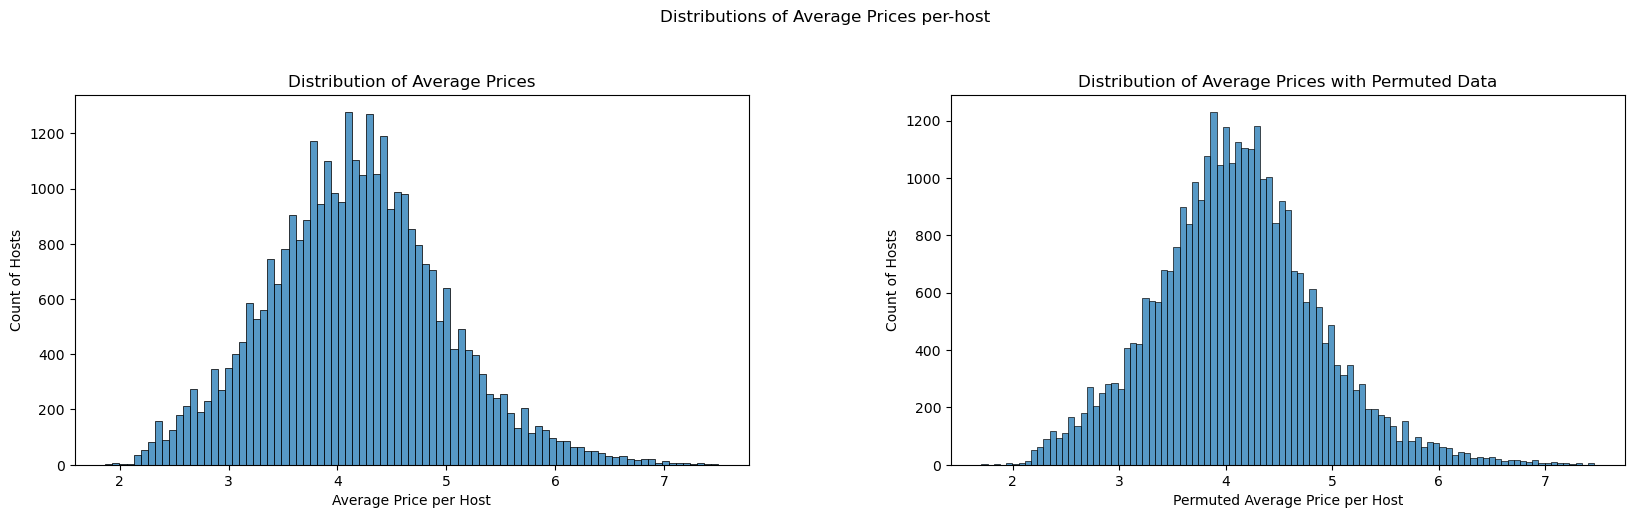

In [337]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.sca(axs[0])
host_pricing = df.groupby('host_id')[['price']].agg('mean')
sns.histplot(x = 'price', data = host_pricing)
plt.xlabel('Average Price per Host')
plt.ylabel('Count of Hosts')
plt.title('Distribution of Average Prices')

plt.sca(axs[1])
perm = df.copy()
perm['host_id'] = perm['host_id'].sample(frac=1, ignore_index=True)
perm = perm.groupby('host_id')[['price']].agg('mean')
sns.histplot(x='price', data=perm)
plt.xlabel('Permuted Average Price per Host')
plt.ylabel('Count of Hosts')
plt.title('Distribution of Average Prices with Permuted Data')

fig.suptitle('Distributions of Average Prices per-host', fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)

The standard deviation is wide but no wider than we would expect by chance. Different hosts do not seem to tend to give different prices.

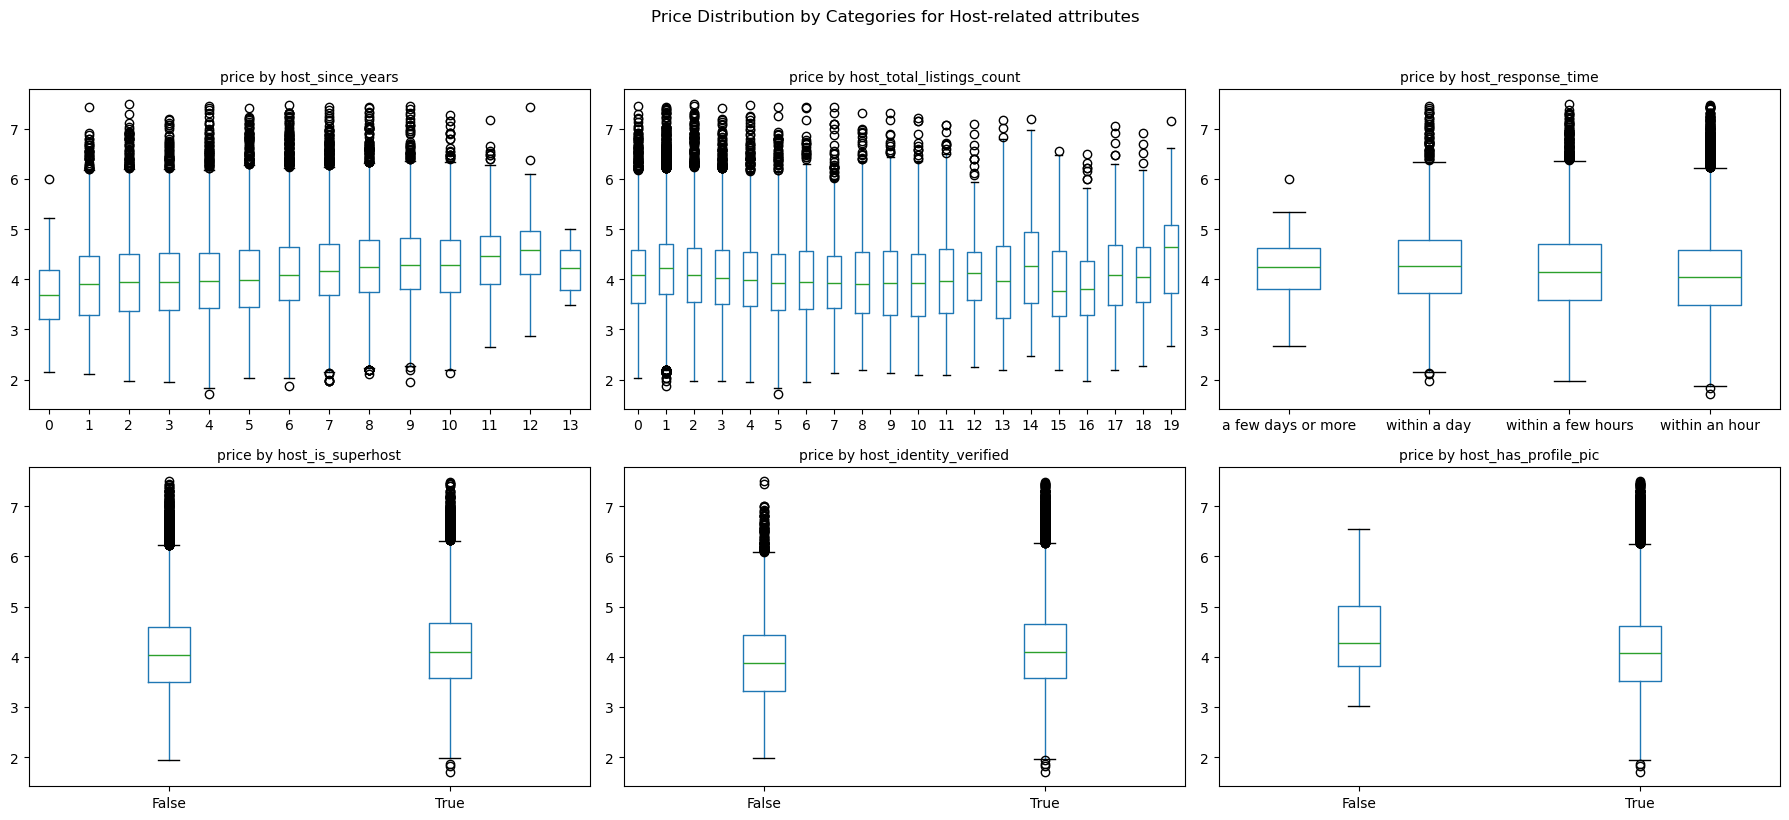

In [339]:
fig, axs = plt.subplots(2, 3, figsize = (18,8))

for i, feature in enumerate(['host_since_years', 'host_total_listings_count','host_response_time','host_is_superhost','host_identity_verified','host_has_profile_pic']):
    row, col = i // 3, i % 3
    boxplot = df[[feature, 'price']].boxplot(by = feature, ax = axs[row, col],grid=False)
    if feature in ['host_is_superhost','host_identity_verified','host_has_profile_pic']:
       xtick_labels = ['False', 'True']
       boxplot.set_xticklabels(xtick_labels)
    axs[row, col].set_title(f'price by {feature}', fontsize=10)
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')

fig.suptitle('Price Distribution by Categories for Host-related attributes',y=1.02, fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

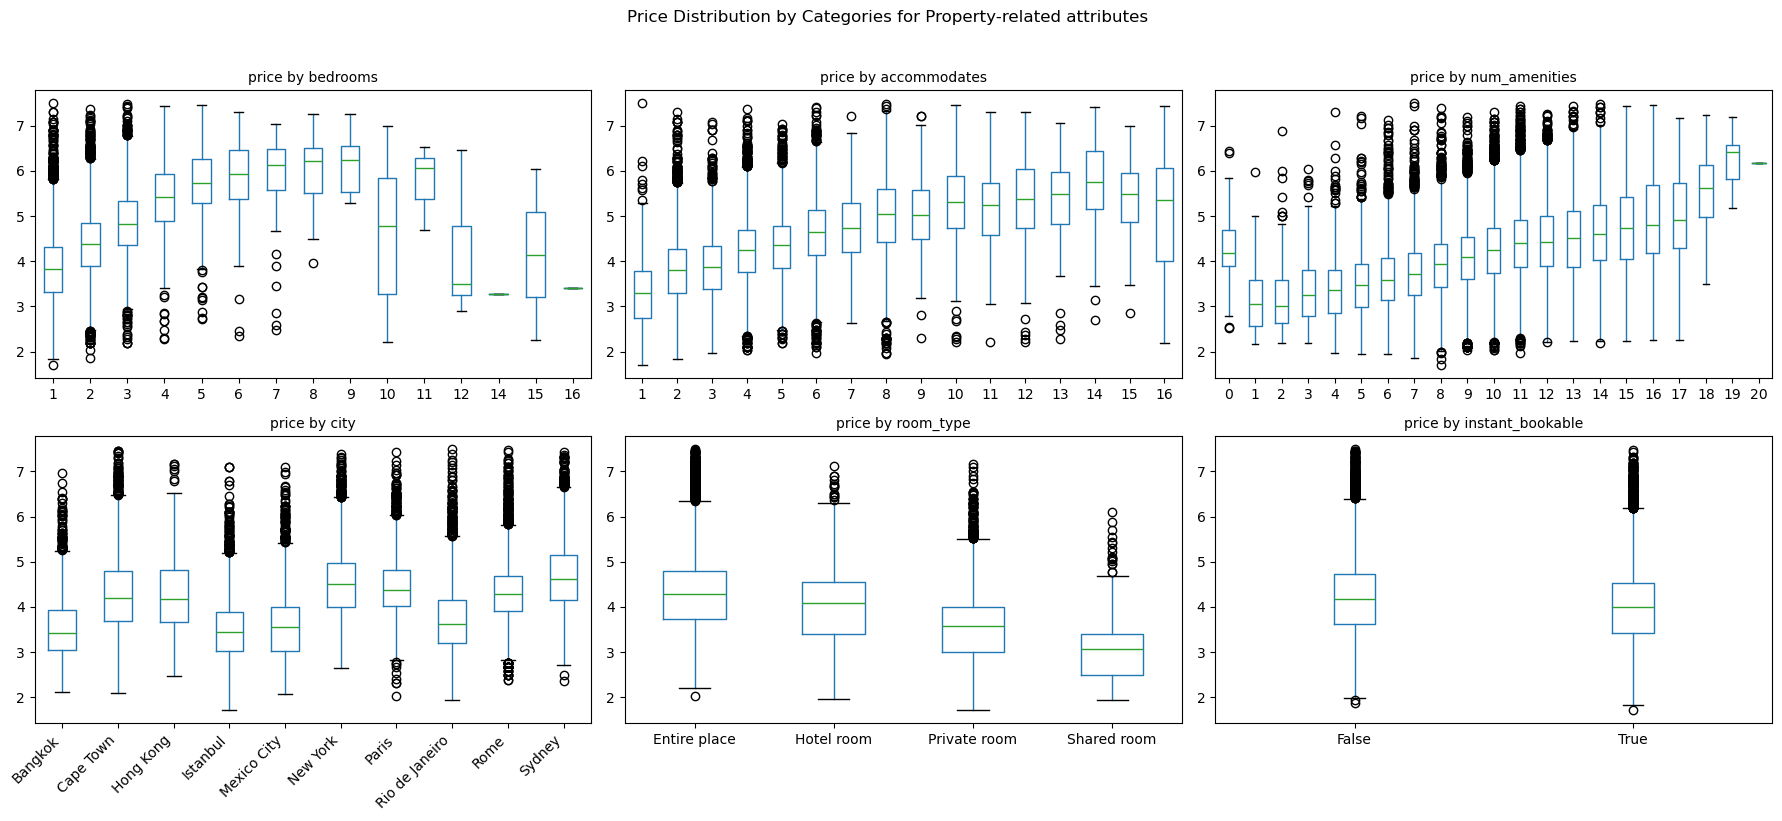

In [118]:
corr = ['bedrooms','accommodates','num_amenities','city', 'room_type','instant_bookable']

# Create the subplot grid
fig, axs = plt.subplots(2, 3, figsize = (18,8))

for i, feature in enumerate(corr):
    row, col = i // 3, i % 3
    boxplot = df[[feature, 'price']].boxplot(by = feature, ax = axs[row, col], grid=False)
    if feature == 'instant_bookable':
       xtick_labels = ['False', 'True']
       boxplot.set_xticklabels(xtick_labels)
    axs[row, col].set_title(f'price by {feature}', fontsize=10)
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')
    if feature == 'city':
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Price Distribution by Categories for Property-related attributes',y=1.02, fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

Correlations with the target variable (price) are primarily with property-related features (such as accommodates, number of amenities, room type), and less with host-related features.

The price demonstrates a subtle decrease when the accommodates reaches 16. Let's explote what might be contributing to this phenomenon:

<Figure size 2000x500 with 0 Axes>

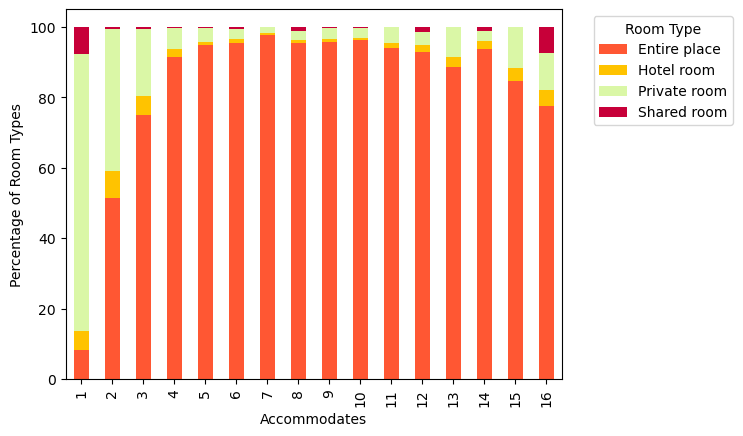

In [120]:
# Calculate the percentage of each room type within each accommodation group
grouped = df.groupby('accommodates')['room_type'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Pivot the DataFrame to have room types as columns and percentages as values
pivot_p = grouped.pivot(index='accommodates', columns='room_type', values='percentage')

# Plotting
plt.figure(figsize=(20, 5))
pivot_p.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039'])
plt.xlabel('Accommodates')
plt.ylabel('Percentage of Room Types')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Further analysis showed that the stagnation in price as the number of people the property can accommodate increases, along with the greater variation for properties accommodating 16 guests, may be explained by room type. Shared rooms, which are popular for this number of guests, are also correlated with lower pricing

Let's check which properties have no services offered yet their prices are unexpectedly higher before the trend of a correlation between the amenities and the price comes into play:

<Figure size 2000x500 with 0 Axes>

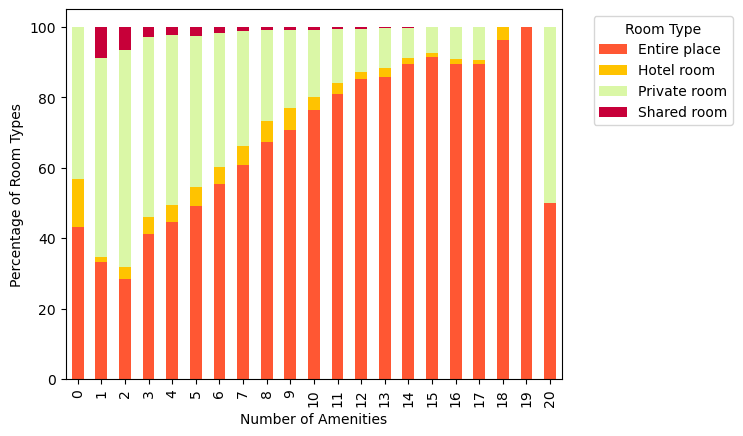

In [123]:
# Calculate the percentage of each room type within each group of number of amenities
grouped = df.groupby('num_amenities')['room_type'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Pivot the DataFrame to have room types as columns and percentages as values
pivot_city = grouped.pivot(index='num_amenities', columns='room_type', values='percentage')

# Plotting
plt.figure(figsize=(20, 5))
pivot_city.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039'])
plt.xlabel('Number of Amenities')
plt.ylabel('Percentage of Room Types')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As the number of amenities in a property increases, there's a higher incidence of entire places, while the opposite trend is observed for rooms. Interestingly, properties with zero amenities are more frequently entire place compared to those with 1-3 amenities, which may explain their unexpectedly high price before the correlation between price and the number of amenities begins.

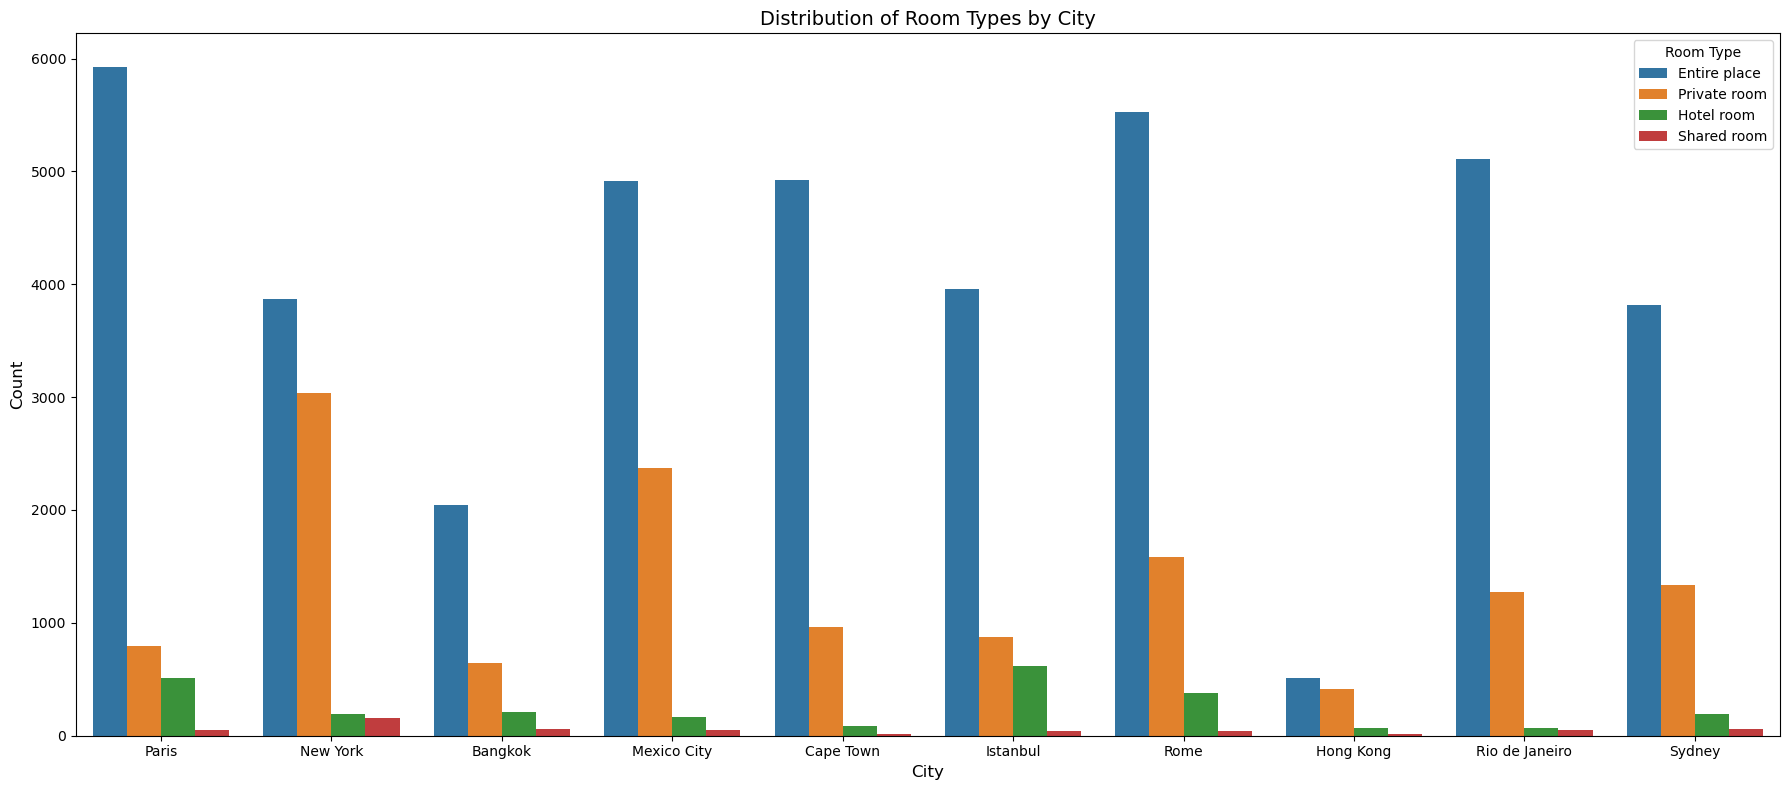

In [125]:
plt.figure(figsize=(18, 8))
sns.countplot(x='city', hue='room_type', data=df)

plt.xlabel('City', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Room Types by City', fontsize=14)
plt.legend(title='Room Type')

plt.tight_layout()
plt.show()

The types of rooms are distributed in the same way among all cities.

## Predictive analytics

### Dataset preparation

#### Cleaning columns

In [130]:
df_backup = df.copy()

In [131]:
df = df.drop(columns=['host_id','name','listing_id','host_since'])

#### Representation of variables

In [133]:
# Get Dummies for categorical features and 0,1 for binary features

BINARY, GET_DUMMIES = ['host_is_superhost','host_identity_verified','instant_bookable','host_has_profile_pic'],['city','room_type','stay_duration','host_response_time']

df = pd.concat((pd.get_dummies(df.loc[:,GET_DUMMIES]),df.drop(columns=GET_DUMMIES)),axis=1).drop(columns=['city_Bangkok','room_type_Hotel room','stay_duration_Flexible','host_response_time_a few days or more'])

for feature in BINARY:
  df[feature] = df[feature].map({True:1, False:0})

#### Data splitting

In [135]:
# Train-Test-Validation Split

TARGET = 'price'

X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = split_data(df, TARGET, frac_test = 0.2, seed = 5)

val_size = X_TEST.shape[0]
X_VAL = X_TRAIN.sample(val_size, random_state=100)
v_inds = X_VAL.index
X_VAL = X_VAL.reset_index(drop=True)
Y_VAL = Y_TRAIN[v_inds]
X_TRAIN = X_TRAIN.drop(index=v_inds).reset_index(drop=True)
Y_TRAIN = np.delete(Y_TRAIN, v_inds)

In [406]:
print('Number of points in the training set {} number of points in the test set {} number of points in the validation set {}'.format(X_TRAIN.shape[0], X_TEST.shape[0], X_VAL.shape[0]))

Number of points in the training set 34167 number of points in the test set 11389 number of points in the validation set 11389


In [137]:
X_TRAIN.columns.tolist() == X_TEST.columns.tolist() == X_VAL.columns.tolist() # Ensure that all categories are represented in each set.

True

#### Transformation

In [139]:
# Standardize all variables to the same units.

x_train_backup = X_TRAIN.copy()
x_val_backup = X_VAL.copy()
x_test_backup = X_TEST.copy()

scaler_standard = StandardScaler()
scaler_standard = scaler_standard.fit(X_TRAIN)

# train

X_TRAIN = pd.DataFrame(scaler_standard.transform(X_TRAIN), columns = X_TRAIN.columns)

# validation

X_VAL = pd.DataFrame(scaler_standard.transform(X_VAL), columns = X_VAL.columns)

# test

X_TEST = pd.DataFrame(scaler_standard.transform(X_TEST), columns = X_VAL.columns)

#### Dimensionality reduction

SequentialFeatureSelector

In [142]:
def mean_squared_error_rounded(y_true, y_pred):
  return np.round(mean_squared_error(y_true, y_pred), 4)

mses_train = {}
mses_val = {}
features = {}

reg_tuning = LinearRegression(fit_intercept=True)
n_features_options = (8,12,15,20,28)

for n_features in n_features_options:
    sfs_forward = SequentialFeatureSelector(reg_tuning, n_features_to_select=n_features,
                                            direction="forward",
                                            scoring=make_scorer(mean_squared_error, greater_is_better=False))
    sfs_forward.fit(X_TRAIN, Y_TRAIN)
    reg_best = LinearRegression(fit_intercept=True).fit(X_TRAIN.loc[:, sfs_forward.get_support()], Y_TRAIN)
    features[n_features] = X_TRAIN.columns[sfs_forward.get_support()]
    mses_train[n_features] = mean_squared_error_rounded(Y_TRAIN, reg_best.predict(X_TRAIN.loc[:, sfs_forward.get_support()]))
    mses_val[n_features] = mean_squared_error_rounded(Y_VAL, reg_best.predict(X_VAL.loc[:, sfs_forward.get_support()]))

all_mses = pd.DataFrame(columns=['number_of_features','train_MSE','val_MSE'])
all_mses['number_of_features'] = features.keys()
all_mses['train_MSE'] = mses_train
all_mses['val_MSE'] = mses_val

<Axes: title={'center': 'Train and Validation mses by Different Number of Features'}, xlabel='Number of Features', ylabel='MSE'>

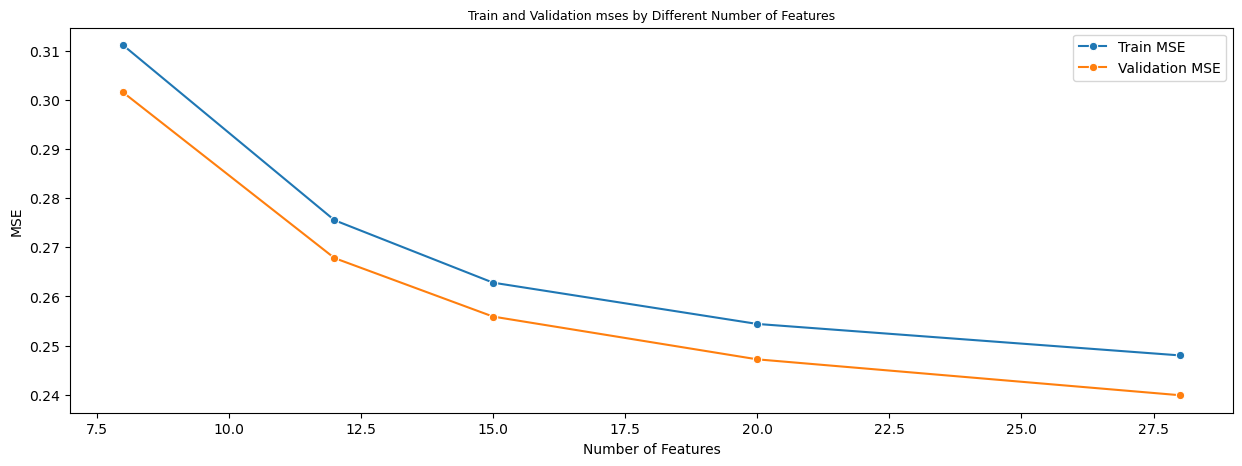

In [143]:
plt.figure(figsize=(15,5))
sns.lineplot(x=n_features_options, y=mses_train.values(), label='Train MSE', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.title('Train and Validation mses by Different Number of Features', fontsize=9)
sns.lineplot(x=n_features_options, y=mses_val.values(), label='Validation MSE', marker='o')

12 features were chosen because the MSE increased moderately up to this point, but then began to rise more sharply.

In [145]:
best_num_features = 12

best_features = features[best_num_features]

X_TRAIN = X_TRAIN[best_features]
X_TEST = X_TEST[best_features]
X_VAL = X_VAL[best_features]

In [146]:
X_TRAIN[best_features].corr(method = 'pearson').style.background_gradient(cmap='coolwarm')

,city_Cape Town,city_Hong Kong,city_Istanbul,city_New York,city_Paris,city_Rome,city_Sydney,room_type_Private room,room_type_Shared room,bedrooms,HEATING,num_amenities
city_Cape Town,1.000000,-0.046801,-0.111678,-0.131195,-0.132232,-0.134346,-0.111583,-0.056996,-0.023906,0.126713,-0.016472,0.120951
city_Hong Kong,-0.046801,1.000000,-0.044173,-0.051893,-0.052303,-0.053139,-0.044136,0.058118,0.009239,-0.010672,-0.081449,-0.068977
city_Istanbul,-0.111678,-0.044173,1.000000,-0.123827,-0.124806,-0.126801,-0.105317,-0.059886,-0.001017,-0.023750,0.212996,0.050779
city_New York,-0.131195,-0.051893,-0.123827,1.000000,-0.146617,-0.148961,-0.123722,0.168787,0.043221,-0.067027,0.260473,0.091145
city_Paris,-0.132232,-0.052303,-0.124806,-0.146617,1.000000,-0.150138,-0.124700,-0.112836,-0.007062,-0.059800,0.261223,-0.056820
city_Rome,-0.134346,-0.053139,-0.126801,-0.148961,-0.150138,1.000000,-0.126693,-0.020567,-0.018698,-0.003278,0.259570,0.024921
city_Sydney,-0.111583,-0.044136,-0.105317,-0.123722,-0.124700,-0.126693,1.000000,0.006835,0.004168,0.062840,0.072209,0.156217
room_type_Private room,-0.056996,0.058118,-0.059886,0.168787,-0.112836,-0.020567,0.006835,1.000000,-0.054429,-0.278737,-0.068302,-0.245130
room_type_Shared room,-0.023906,0.009239,-0.001017,0.043221,-0.007062,-0.018698,0.004168,-0.054429,1.000000,-0.057404,-0.017870,-0.056308
bedrooms,0.126713,-0.010672,-0.023750,-0.067027,-0.059800,-0.003278,0.062840,-0.278737,-0.057404,1.000000,0.005567,0.245199


No significant multicollinearity was observed due to correlations between the selected independent variables.

### Linear Regression

In [149]:
reg = LinearRegression(fit_intercept=True).fit(X_TRAIN, Y_TRAIN)

#### Model evaluation

In [151]:
BASLINE = add_baseline(Y_TRAIN,Y_TEST)
BASLINE

{'model': 'baseline',
 'mse train': 0.715,
 'mse test': 0.715,
 'number of features': 0}

In [152]:
add_model('LINEAR REGRESSION', reg, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

{'model': 'LINEAR REGRESSION',
 'mse train': 0.275,
 'mse test': 0.276,
 'number of features': 12}

Beginning with the estimation of MSE was a valuable initial step as it enabled to effectively compare models. To gain a more comprehensive understanding of the model's performance I'll enhance evaluation by incorporating additional indices including RMSE | MAE | $R^2$  as well as their CI.

In [154]:
{'model': 'LINEAR REGRESSION',
          'rmse train': np.round(np.sqrt(mean_squared_error(Y_TRAIN, reg.predict(X_TRAIN))), 3),
          'rmse test': np.round(np.sqrt(mean_squared_error(Y_TEST, reg.predict(X_TEST))), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'rmse train': 0.525,
 'rmse test': 0.526,
 'number of features': 12}

In [155]:
{'model': 'LINEAR REGRESSION',
          'mae train': np.round(mean_absolute_error(Y_TRAIN, reg.predict(X_TRAIN)), 3),
          'mae test': np.round(mean_absolute_error(Y_TEST, reg.predict(X_TEST)), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'mae train': 0.399,
 'mae test': 0.402,
 'number of features': 12}

In [156]:
{'model': 'LINEAR REGRESSION',
          'explained variance train': np.round(r2_score(Y_TRAIN, reg.predict(X_TRAIN)), 3),
          'explained variance test': np.round(r2_score(Y_TEST, reg.predict(X_TEST)), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'explained variance train': 0.615,
 'explained variance test': 0.614,
 'number of features': 12}

Instead of comparing the test RMSE as a measure of generalization, I would like to have a more trusted comparison. Therefore I bootstrap the test set (resample with replacements) and compare the average RMSE. In addition, I'll estimate how spread is the distribution of possible RMSES by computing the SD as well as CI of the average RMSE.

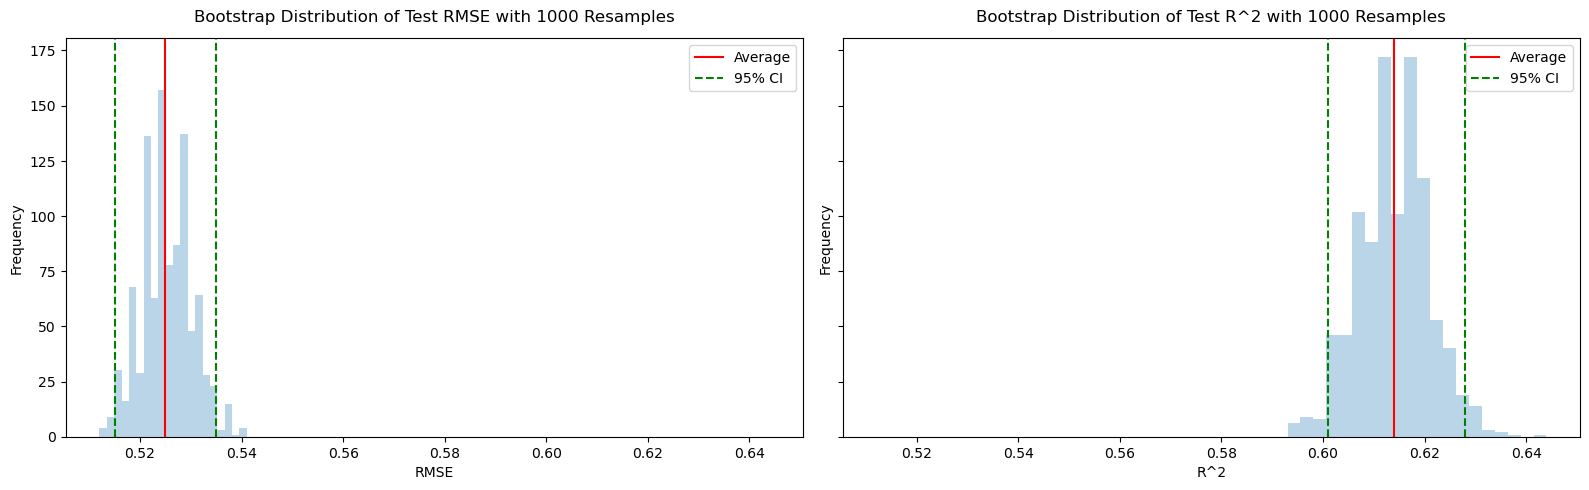

average RMSE: 0.5252840000000001 SD RMSE: 0.005 average R^2: 0.6139369999999998 SD R^2: 0.005


In [158]:
RMSES = []
R = []

num_rep = 1000
test_size = X_TEST.shape[0]
for i in range(num_rep):
  np.random.seed(i + 1)
  inds = np.random.choice(test_size, test_size, replace=True)
  X_TEST_I = X_TEST.loc[inds,:]
  Y_TEST_I = Y_TEST[inds]
  mse = mean_squared_error(Y_TEST_I, reg.predict(X_TEST_I))
  RMSES.append(np.round(np.sqrt(mse), 3))
  R.append(np.round(r2_score(Y_TEST_I, reg.predict(X_TEST_I)), 3))

my_dict = {'RMSE' : RMSES, 'R^2' : R}

i = 0
fig, ax = plt.subplots(1,2,figsize = (16,5), sharex=True, sharey=True)
for k, v in my_dict.items():
  ax[i].hist(v, bins=20, alpha=0.3)
  avg = np.round(np.mean(v), 3)
  lower = np.percentile(v, 2.5)
  upper = np.percentile(v, 97.5)
  ax[i].set_title('Bootstrap Distribution of Test ' + k + ' with 1000 Resamples',y=1.02)
  ax[i].axvline(avg, c='r', ls='-', label="Average")
  ax[i].axvline(lower, c='g', ls='--', label="95% CI")
  ax[i].axvline(upper, c='g', ls='--')
  ax[i].set_xlabel(k)
  ax[i].set_ylabel('Frequency')
  ax[i].legend(loc='upper right')
  i += 1

plt.tight_layout()
plt.show()

print('average RMSE: {} SD RMSE: {} average R^2: {} SD R^2: {}'.format(np.mean(RMSES), np.std(RMSES).round(3), np.mean(R), np.std(RMSES).round(3)))

The error measures show that the regression model performs better than the base model. The small difference between the training and test errors indicates that the model is not overfitting. RMSE and MAE provide insight into the typical size of the percentages of errors. The explained variance shows that the model fails to explain about 40% ~ of the variance in the target variable. The relatively small confidence intervals indicate good consistency in performance.

To evaluate the impact on the model's performance as a measure of uncertainty I'll perform a **sensitivity analysis** to assess the model stability to a noisy target and random data (I'll add noise and permuted the target).

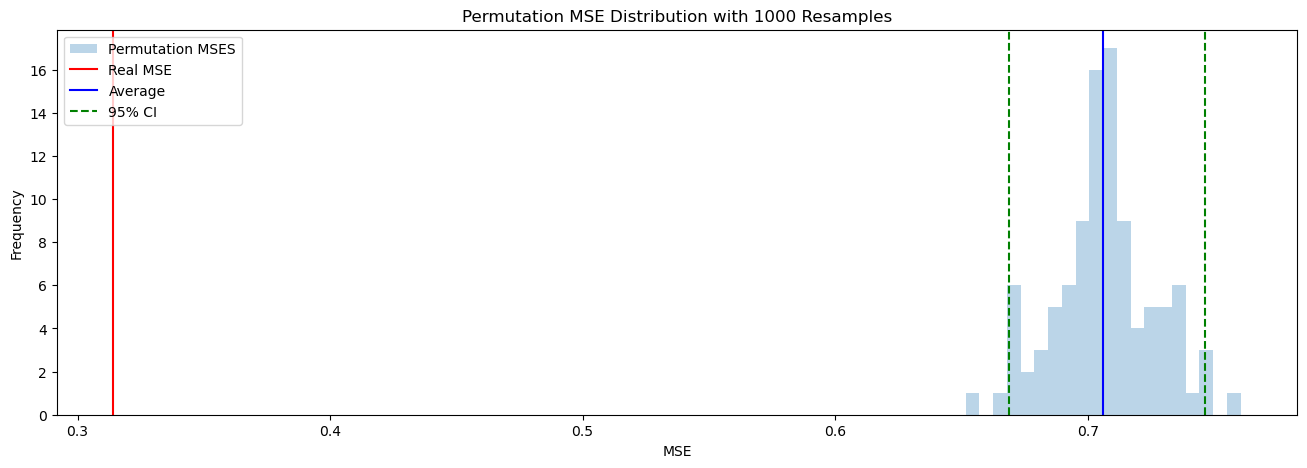

In [161]:
STD_TRAIN = round(np.std(Y_TRAIN, ddof=1), 2)
train_size = Y_TRAIN.size
TEST_MSE = mean_squared_error(Y_TEST, reg.predict(X_TEST))

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

# 10,000 datapoints
subset_size = 10000
random_indices = X_TRAIN.sample(subset_size, replace=False).index
X_subset = X_TRAIN.iloc[random_indices]
Y_subset = Y_TRAIN[random_indices]

# Calculate real MSE
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42)
model_real = LinearRegression(fit_intercept=True).fit(X_train_real, y_train_real)
preds_real = model_real.predict(X_test_real)
real_mse = mean_squared_error(y_test_real, preds_real)

# Permutation test or the resampling test.
permuted_mses = []
permutation_iters = 100
for i in range(permutation_iters):
    # Shuffle the indices to randomly assign the target labels to samples
    np.random.shuffle(Y_subset)
    # When we obtain train and test splits, the assignments are random.
    X_train, X_test, y_train, y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    permuted_mses.append(mean_squared_error(y_test, preds))


# plot

fig, ax = plt.subplots(figsize=(16,5))
ax.hist(permuted_mses, bins=20, alpha=0.3, label="Permutation MSES")
ax.axvline(real_mse, c='r', ls='-', label="Real MSE")
avg = np.round(np.mean(permuted_mses), 3)
lower = np.percentile(permuted_mses, 2.5)
upper = np.percentile(permuted_mses, 97.5)
ax.axvline(avg, c='b', ls='-', label="Average")
ax.axvline(lower, c='g', ls='--', label="95% CI")
ax.axvline(upper, c='g', ls='--')
ax.set_title("Permutation MSE Distribution with 1000 Resamples")
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')
plt.show()

In [162]:
print('STD train {}'.format(STD_TRAIN))

STD train 0.8500000238418579


Text(0.5, 1.0, 'MSES by adding different levels of noise to the target variable')

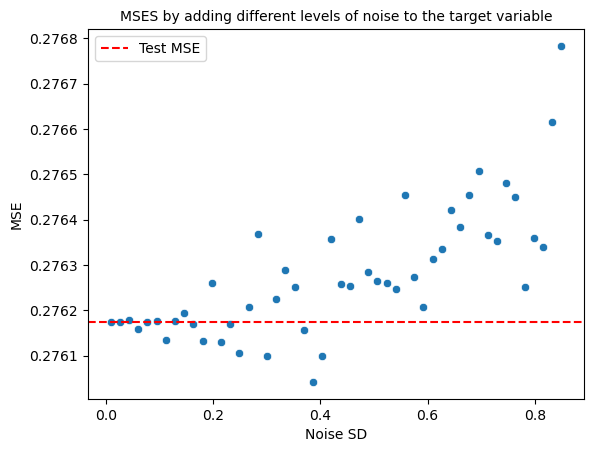

In [163]:
sigmas = np.linspace(STD_TRAIN / 100, STD_TRAIN, 50)
all_mses = []
for sigma in sigmas:
  Y_train_noise = Y_TRAIN.copy() + np.random.normal(loc=0, scale=sigma, size=train_size)
  lr_model = LinearRegression(fit_intercept=True).fit(X_TRAIN, Y_train_noise)
  all_mses.append(mean_squared_error(Y_TEST, lr_model.predict(X_TEST)))

fig, ax = plt.subplots()
ax.axhline(TEST_MSE, label='Test MSE', c='r', ls='--')
sns.scatterplot(x=sigmas, y=all_mses, ax=ax)
ax.set_xlabel('Noise SD')
ax.set_ylabel('MSE')
ax.set_title('MSES by adding different levels of noise to the target variable', fontsize=10)

The sensitivity analysis (using permutations and adding noise to the target variable) shows that the regression model is stable and relatively resistant to noise. Adding reasonable noise to the target variable did not significantly affect the model's performance. In particular, with small noise levels, the model remains almost unchanged. When noise exceeds 0.2, the MSE increases, but this change is not noticeable due to the small range of values on the Y-axis. The model performs better on the original data compared to random data, indicating that the generalization error (GE) is unlikely to vary greatly and is not heavily dependent on specific data.

#### Feature importance

In [166]:
coefs = {}
for i, fearure in enumerate(X_TRAIN.columns):
   coefs[fearure] = round(reg.coef_[i], 3)
coefs['intercept'] = round(reg.intercept_, 3)
dict(sorted(coefs.items(), key=lambda item: abs(item[1]),reverse=True))

{'intercept': 4.102,
 'bedrooms': 0.329,
 'city_New York': 0.322,
 'city_Sydney': 0.254,
 'city_Paris': 0.251,
 'room_type_Private room': -0.212,
 'city_Rome': 0.209,
 'num_amenities': 0.138,
 'city_Cape Town': 0.121,
 'city_Hong Kong': 0.104,
 'room_type_Shared room': -0.094,
 'city_Istanbul': -0.076,
 'HEATING': 0.009}

The linear regression coefficients are presented in order of importance. They show that a one standard deviation (SD) increase in an attribute will cause a corresponding increase or decrease in the price log, reflecting the percentage change in price. The intercept represents the expected value of y when all x values are zero. Most coefficients are positive, indicating a positive correlation with the target variable. Specifically, cities in developed countries, along with properties that have more rooms and better amenities, are associated with higher prices. Conversely, cities in developing countries (such as Istanbul) and smaller properties correlate with lower prices. Heating may be a desirable feature, especially in colder climates, though it is less important compared to factors like city, property type, size, and available amenities. These findings align with my expectations: cities in developed countries tend to be more expensive, and features with high correlation to the target variable are likely to be strong predictors.

#### Error analysis

I'll begin by creating a plot that provides us with insights into the model's errors.

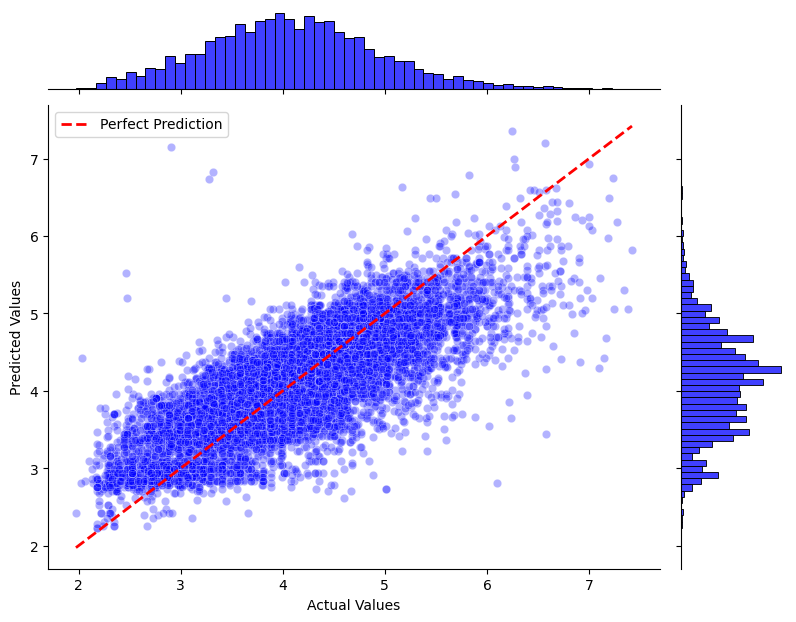

In [170]:
grid = sns.jointplot(x=Y_TEST, y=reg.predict(X_TEST), kind='scatter', color='Blue', alpha=0.3, height=8)
grid.figure.set_size_inches(8,6)
plt.plot([min(Y_TEST), max(Y_TEST)], [min(Y_TEST), max(Y_TEST)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

The errors seem relatively balanced, which is a good sign as the model doesn't systematically predict prices that are too high or too low. However, for extremely low prices (between 2 and 3 on a logarithmic scale), the model tends to predict higher prices, and for extremely high prices (between 6 and 7), it predicts lower prices. This suggests that the model struggles to effectively distinguish between very high and very low prices. Consequently, the histogram of predicted prices shows less variance compared to the histogram of actual values.

My challenges might be tied to the dimensionality reduction technique which is **not** a straightforward process and lacks a universal solution.

Thinking that dimensions identified as significant by the high correlation technique might enhance the model's ability to distinguish between high-priced and low-priced properties, I'll combine them with the current dimensions and re-ran the model.

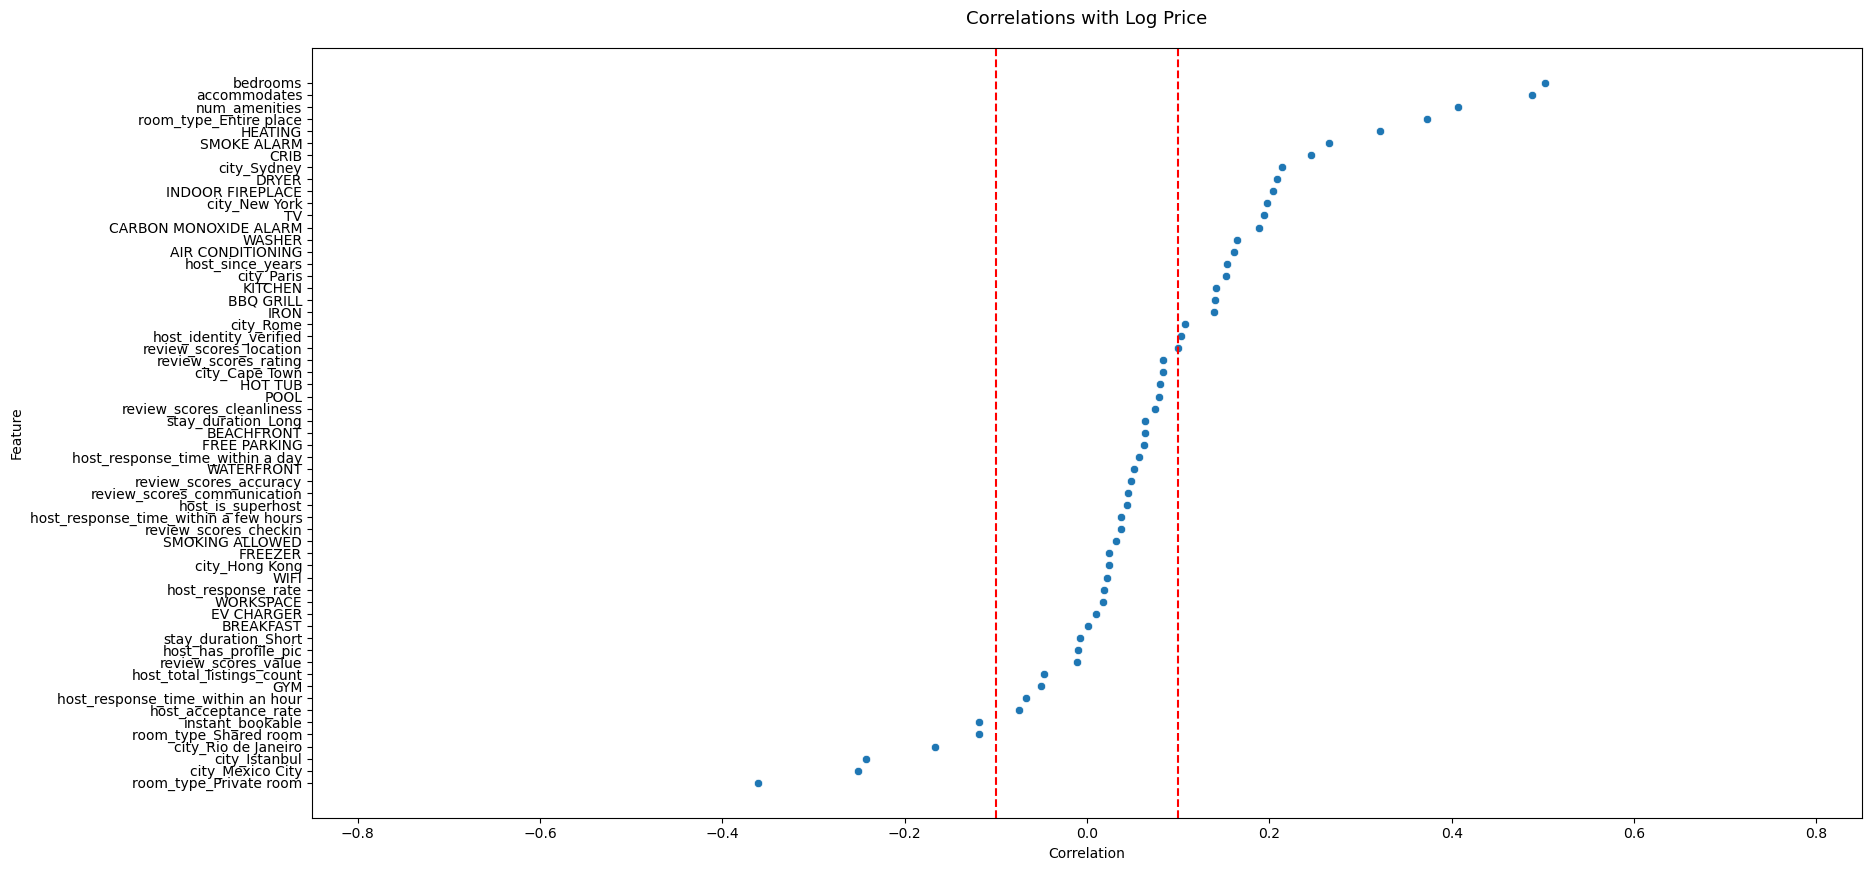

In [176]:
df_cor = df.drop(columns='price')
corr_with_target = df_cor.corrwith(df['price'], method='pearson').round(3).reset_index().rename(columns = {'index' : 'feature', 0 : 'correlation_with_target'}).sort_values(by = 'correlation_with_target', ascending = False).reset_index(drop=True)
best_features_cor = list(corr_with_target.loc[corr_with_target['correlation_with_target'] > 0.1, :]['feature'].values)

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=corr_with_target, x='correlation_with_target', y='feature', ax=ax)
ax.axvline(x=0.1, color='r', linestyle='--')
ax.axvline(x=-0.1, color='r', linestyle='--')
ax.set_yticks(corr_with_target.index)
ax.set_xlim(-0.85,0.85)
ax.set_xlabel('Correlation')
ax.set_ylabel('Feature')
ax.set_title('Correlations with Log Price', y=1.02, fontsize=13)
plt.show()

In [178]:
THRESHOLD = 0.1

new_features = set(best_features_cor) | set(best_features) # taking the features that came out with the two techniques

x_train_backup = x_train_backup[list(new_features)]
x_val_backup = x_val_backup[list(new_features)]
x_test_backup = x_test_backup[list(new_features)]

In [180]:
reg_new = LinearRegression(fit_intercept=True).fit(x_train_backup, Y_TRAIN)

In [182]:
{'model' : 'LR with more features',
            'mse train': np.round(mean_squared_error(Y_TRAIN, reg_new.predict(x_train_backup)), 3),
            'mse validation': np.round(mean_squared_error(Y_VAL, reg_new.predict(x_val_backup)), 3),
            'mse test': np.round(mean_squared_error(Y_TEST, reg_new.predict(x_test_backup)), 3),
            'number of features': x_train_backup.shape[1]}

{'model': 'LR with more features',
 'mse train': 0.26,
 'mse validation': 0.252,
 'mse test': 0.262,
 'number of features': 27}

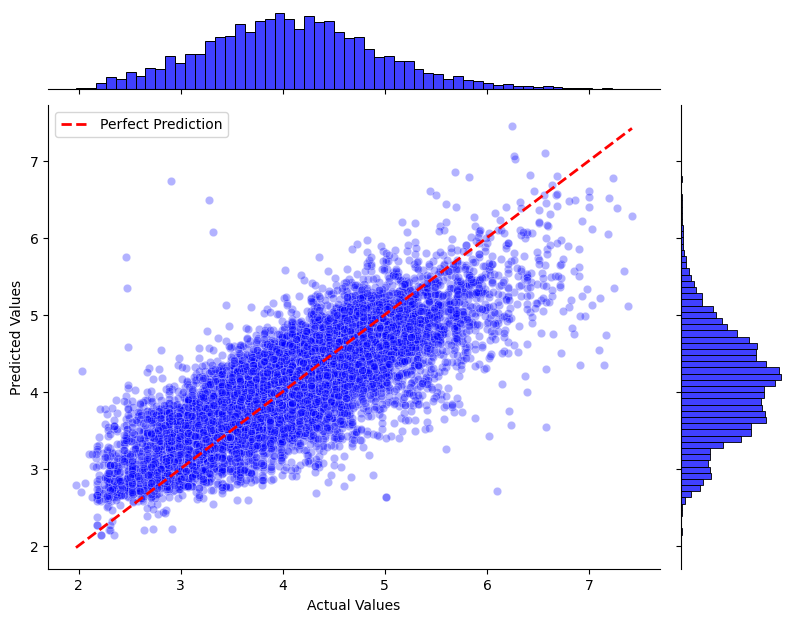

In [184]:
grid = sns.jointplot(x=Y_TEST, y=reg_new.predict(x_test_backup), kind='scatter', color='Blue', alpha=0.3, height=8)
grid.figure.set_size_inches(8,6)
plt.plot([min(Y_TEST), max(Y_TEST)], [min(Y_TEST), max(Y_TEST)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

A small decrease in test error was observed, indicating a slight improvement in the model's ability to distinguish between price ranges, though this ability remains limited. Despite the improvement, the histogram of predicted values shows more valleys, suggesting that the model may not fully capture certain complexities in the data or the underlying relationship in the data might not be entirely linear.

## Future directions

A continuation of this project could involve using non-linear models, such as Random Forest. This method can capture complex or non-linear relationships between attributes and the target variable that linear regression might miss. Data science is an iterative process - I started with a simple model, evaluated its performance, and then recognized the need for and benefits of transitioning to more complex models and comparing different models (model selection).